**IMDb**（Internet Movie Datebase ）是全球最大的互联网影视数据库，而[Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) 是一个根据IMDB上电影评论而建立的数据集。它由斯坦福大学于 2011 年发布。

![image-20201226152702981](images/image-20201226152702981.png)

## 获取数据

首先引入需要的包。

In [4]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from nltk.corpus import stopwords
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 

base_path = os.path.abspath('/tf/eipi10/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# 设置GPU内存自动扩增
qtf.utils.set_gpu_memory_growth()
nltk.download('stopwords')

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# 当module有新的方法的时候，需要运行下面方法。
%reload_ext autoreload

初始化参数。

In [32]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr



output_path = os.path.abspath('./output')
data_name = 'imdb'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['Negative', 'Positive']

params = {
    'data_name': data_name,
    'data_path': data_path,
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'text_columns': 'snps_sa_comments',
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'stop_words':stopwords.words('english'),
    'batch_size': 32,    
    'max_features': 20000,
    'sequence_length': 500,    
    'epochs': 3,    
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':True,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'model_params':{
        'mlp':{'dropout':0.6, 'layer_count':1, 'units':256, 'epochs':15},
        'rnn':{'dropout':0.4, 'embedding_dim':200, 'units':200, 'epochs':5},
        'embedding':{'dropout':0.4, 'embedding_dim':200, 'epochs':15},
        'sepcnn':{'dropout':0.4, 'epochs': 10, 'batch_size':128},
        'tl':{'dropout':0.4, 'trainable':True, 'layer_count':1, 'unit':64, 'epochs': 10},
        'pg':{'dropout':0.4, 'embedding_dim':300, 'units':80, 'epochs':20, 'learning_rate':0.0005},  
    },
    'embedding_paths':{
        'cc_en_300':os.path.join(word_vectors_path, 'snps', 'cc.en.300.vec'),
        'fasttext_crawl_300d_2M':os.path.join(word_vectors_path, 'fasttext-crawl-300d-2M.vec'),
        'glove_twitter_27B_200d':os.path.join(word_vectors_path, 'glove.twitter.27B.200d.txt')
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
# model_results.clear()

2021-07-21 05:31:33,643: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/results.json


### 下载数据

开始下载数据。

In [7]:
dataset_dir =  os.path.join(os.path.expanduser('~'), '.keras/datasets/aclImdb') 
if not os.path.exists(dataset_dir):
    url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
    dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url, untar=True)
    dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
    print(dataset_dir)

![image-20201217095446441](images/image-20201217095446441.png)

下面是压缩文件解开后的目录结构。

![image-20201104115404253](images/image-20201104115404253.png)

其中train和test目录包含了实际的文本数据，详细说明见[IMDB](https://eipi10.cn/others/2020/10/22/dataset/#imdb---large-movie-review-dataset)。

### 查看数据

下面看一看实际的数据是啥样的。

In [8]:
def get_files(base_dir):
    pos_dir = os.path.join(base_dir, 'pos')
    pos_files = os.listdir(pos_dir)
    pos_files = [os.path.join(pos_dir, file_name) for file_name in pos_files]
    
    neg_dir = os.path.join(base_dir, 'neg')
    neg_files = os.listdir(neg_dir)
    neg_files = [os.path.join(neg_dir, file_name) for file_name in neg_files]    

    return pos_files, neg_files

train_pos_files, train_neg_files = get_files(os.path.join(dataset_dir, 'train'))
test_pos_files, test_files = get_files(os.path.join(dataset_dir, 'test'))
    
print('train dataset: {} positive reviews, {} negative reviews'.format(len(train_pos_files), len(train_neg_files)))
print('test dataset: {} positive reviews, {} negative reviews'.format(len(test_pos_files), len(test_files)))

train dataset: 12500 positive reviews, 12500 negative reviews
test dataset: 12500 positive reviews, 12500 negative reviews


![image-20201217115036617](images/image-20201217115036617.png)

首先看一看正面的评论。

In [9]:
for file_path in train_pos_files[0:3]:    
    print('-'*30 + file_path + '-'*30 )
    with open(file_path) as f:
        comment = f.read() 
        print(comment if len(comment)<=800 else comment[0:800]+' ...') 

------------------------------/root/.keras/datasets/aclImdb/train/pos/127_7.txt------------------------------
Zentropa has much in common with The Third Man, another noir-like film set among the rubble of postwar Europe. Like TTM, there is much inventive camera work. There is an innocent American who gets emotionally involved with a woman he doesn't really understand, and whose naivety is all the more striking in contrast with the natives.<br /><br />But I'd have to say that The Third Man has a more well-crafted storyline. Zentropa is a bit disjointed in this respect. Perhaps this is intentional: it is presented as a dream/nightmare, and making it too coherent would spoil the effect. <br /><br />This movie is unrelentingly grim--"noir" in more than one sense; one never sees the sun shine. Grim, but intriguing, and frightening.
------------------------------/root/.keras/datasets/aclImdb/train/pos/126_10.txt------------------------------
Zentropa is the most original movie I've seen in y

![image-20201217111649607](images/image-20201217111649607.png)

然后看一看负面的评论。

In [10]:
for file_path in train_neg_files[0:3]:    
    print('-'*30 + file_path + '-'*30 )
    with open(file_path) as f:
        comment = f.read() 
        print(comment if len(comment)<=800 else comment[0:800]+' ...')

------------------------------/root/.keras/datasets/aclImdb/train/neg/127_4.txt------------------------------
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher ...
------------------------------/root/.keras/datasets/aclImdb/train/neg/126_1.txt------

![image-20201217100213645](images/image-20201217100213645.png)

## 探索数据

接下来，对把数据加载进内存，进行深入一些的探索。

### 基本信息

In [11]:
def get_samples(texts, labels, rate):
    indexs = np.arange(len(texts))
    sample_indexs, _, sample_labels, _ = train_test_split(indexs, labels,                                                          
                                                          test_size=1-rate,
                                                          random_state=12)
    sample_texts = [texts[index] for index in sample_indexs]
    return sample_texts, sample_labels    

def load_imdb_sentiment_analysis_dataset(imdb_data_path, seed=123):
    """Loads the IMDb movie reviews sentiment analysis dataset.

    # Arguments
        data_path: string, path to the data directory.
        seed: int, seed for randomizer.

    # Returns
        A tuple of training and validation data.
        Number of training samples: 25000
        Number of test samples: 25000
        Number of categories: 2 (0 - negative, 1 - positive)

    # References
        Mass et al., http://www.aclweb.org/anthology/P11-1015

        Download and uncompress archive from:
        http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    """

    # Load the training data
    train_texts = []
    train_labels = []
    for category in ['pos', 'neg']:
        train_path = os.path.join(imdb_data_path, 'train', category)
        for fname in sorted(os.listdir(train_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(train_path, fname)) as f:
                    train_texts.append(f.read())
                train_labels.append(0 if category == 'neg' else 1)

    # Load the validation data.
    test_texts = []
    test_labels = []
    for category in ['pos', 'neg']:
        test_path = os.path.join(imdb_data_path, 'test', category)
        for fname in sorted(os.listdir(test_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(test_path, fname)) as f:
                    test_texts.append(f.read())
                test_labels.append(0 if category == 'neg' else 1)

    # Shuffle the training data and labels.
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)

    return ((train_texts, np.array(train_labels)),
            (test_texts, np.array(test_labels)))

(train_texts, train_labels), (test_texts, test_labels) = load_imdb_sentiment_analysis_dataset(dataset_dir)

if params.sample_perecent<1:
    train_texts, train_labels = get_samples(train_texts, train_labels, rate=params.sample_perecent)
    test_texts, test_labels = get_samples(test_texts, test_labels, rate=params.sample_perecent)

print('train_texts.length={}, train_labels.shape={}'.format(len(train_texts), train_labels.shape))
print('test_texts.length={}, test_labels.shape={}'.format(len(test_texts), test_labels.shape))

train_texts.length=25000, train_labels.shape=(25000,)
test_texts.length=25000, test_labels.shape=(25000,)


![image-20201217122349480](images/image-20201217122349480.png)

### 类别分布

下面看看类别的分布。可以看到数据分为Positive和Negative两类，数据分布完全均匀。

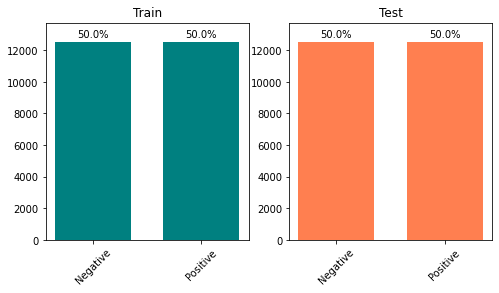

In [12]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



### 文本长度分布

分析训练集和测试集的文本长度分布是否相似。

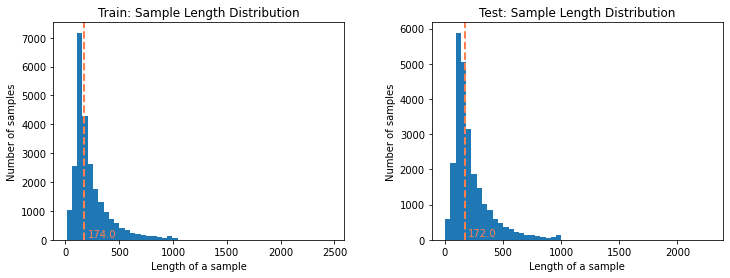

train：mean=233.79 variance=30181.96
test：mean=228.53 variance=28520.56


In [13]:
train_text_lengths = [len(s.split()) for s in train_texts]
test_text_lengths = [len(s.split()) for s in test_texts]
qtf.utils.plot_length_distribution(train_text_lengths, test_text_lengths)

print('train：mean={:0.2f} variance={:0.2f}'.format(np.mean(train_text_lengths), 
                                                    np.var(train_text_lengths)))
print('test：mean={:0.2f} variance={:0.2f}'.format(np.mean(test_text_lengths), 
                                                   np.var(test_text_lengths)))


通过图形，中位数，均值和方差的比较，可以认为训练集和测试集文本长度的分布是非常相似的。下面用卡方检验来比较训练集和测试集是否有显著差异。

In [14]:
def process_length(lengths):
    cut_points = [0,99,199,299,399,499,599,699,799,10000]
    labels = ["0-99","100-199","200-299","300-399","400-499","500-599", "600-699","700-799","800+"]
    return pd.cut(lengths, cut_points, labels=labels)

def get_observed(df, column1, column2):
    df_observed = pd.crosstab(
        df[column1],
        df[column2]
    )    
    return df_observed
    
def get_expected(df_observed):
    observed = df_observed.to_numpy()
    reduce_row = observed.sum(axis=0, keepdims=True)/observed.sum()
    reduce_col = observed.sum(axis=1, keepdims=True)

    expected = reduce_col.dot(reduce_row)
    df_expected = pd.DataFrame(expected, index=df_observed.index, columns=df_observed.columns)
    return df_expected
  
def show_sum(df):
    df.columns =  df.columns.tolist()  
    df = df.reset_index()
    s = df.melt(df.columns[0], var_name=' ')
    ct = pd.crosstab(index=s[df.columns[0]], columns=s.iloc[:,1], values=s.value, 
                     aggfunc='sum', margins=True, margins_name='合计',
                     rownames=[''], 
               ) 
    display(ct)
    
length = train_text_lengths + test_text_lengths
dataset = ['train']*len(train_text_lengths) + ['test']*len(test_text_lengths)

df_length = pd.DataFrame({"dataset":dataset, "length":length})
df_length['len'] = process_length(length)
df_observed = get_observed(df_length, 'dataset', 'len')
# display(df_length)

print('-'*25, 'Observed', '-'*25)
show_sum(df_observed)

print('-'*25, 'Expected', '-'*25)
df_expected = get_expected(df_observed)
show_sum(df_expected)

------------------------- Observed -------------------------


,0-99,100-199,200-299,300-399,400-499,500-599,600-699,700-799,800+,合计
,,,,,,,,,,
test,3091,11744,4697,2321,1251,752,434,289,421,25000
train,2926,11654,4665,2385,1340,786,464,307,473,25000
合计,6017,23398,9362,4706,2591,1538,898,596,894,50000


------------------------- Expected -------------------------


,0-99,100-199,200-299,300-399,400-499,500-599,600-699,700-799,800+,合计
,,,,,,,,,,
test,3008.5,11699.0,4681.0,2353.0,1295.5,769.0,449.0,298.0,447.0,25000.0
train,3008.5,11699.0,4681.0,2353.0,1295.5,769.0,449.0,298.0,447.0,25000.0
合计,6017.0,23398.0,9362.0,4706.0,2591.0,1538.0,898.0,596.0,894.0,50000.0


![image-20210101174143400](images/image-20210101174143400.png)

然后进行卡方检验。可以看到p_value>0.05，所以接受原假设——数据集来源和文本长度是独立的，也就是说接受训练集和测试集是是相似的分布。

In [15]:
observed = df_observed.to_numpy()
expected = df_expected.to_numpy()

chi_squared_stat = ((observed-expected)**2/expected).sum()
print('chi_squared_stat =', chi_squared_stat)

df = np.prod(np.array(observed.shape) - 1)
critical_value  = stats.chi2.ppf(q=0.95, df=df)  #0.95:置信水平, df:自由度
print('critical_value =', critical_value)        #临界值:拒绝域的边界, 当卡方值大于临界值，则原假设不成立，备择假设成立

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df=df)
print('p_value =', p_value)

chi_squared_stat = 14.229826210223425
critical_value = 15.50731305586545
p_value = 0.07596828551367163



### 词频分布

分析训练集和测试集的词频分布是否相似。下面代码中，去除了一些stopwords。

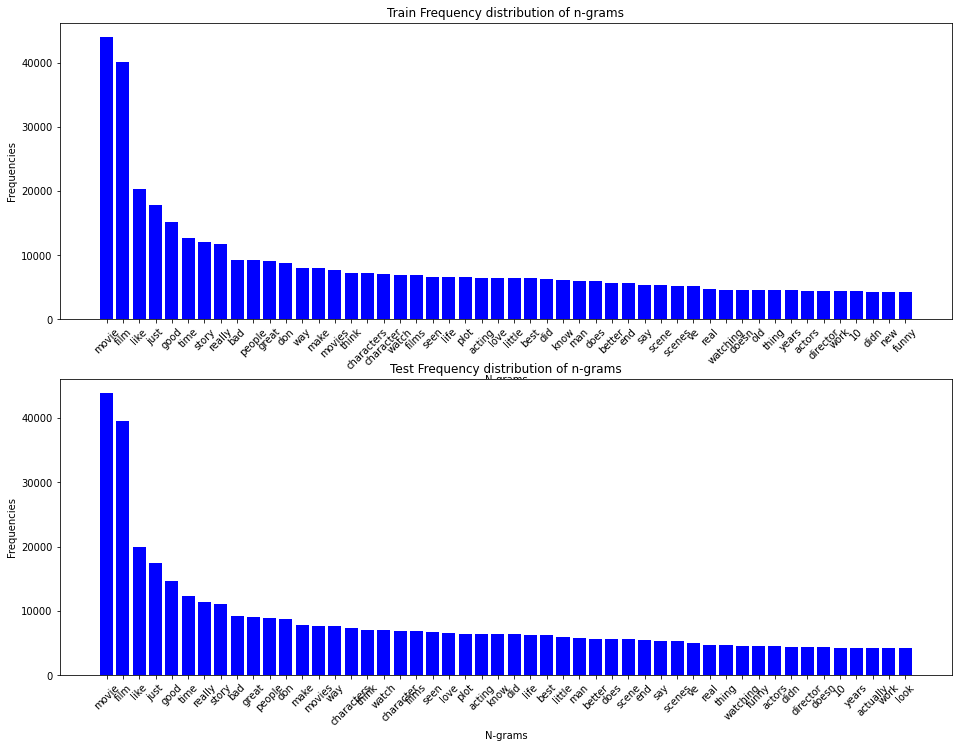

In [16]:
qtf.utils.plot_frequency_distribution(train_texts, test_texts) 

In [17]:
word_counter = Counter()
for s in train_texts:
    word_counter.update(s.split())
for s in test_texts:
    word_counter.update(s.split())   

print('Number of Vocabulary: {}'.format(len(word_counter)))

for word in list(word_counter):
    if word_counter[word]<25: word_counter.pop(word)
        
print('Number of Vocabulary: {}'.format(len(word_counter)))

Number of Vocabulary: 438729
Number of Vocabulary: 23078


![image-20201217142728260](images/image-20201217142728260.png)

上面可以看到词频大于等于100次的词汇有7706个。

## 准备数据

不同的模型需要准备不同的数据，所以徐要确定一下要构建哪种模型。

### 模型选择

下图是google在两年前提出一个选择流程图。

![image-20201217135347743](images/image-20201217135347743.png)

1. Calculate the number of samples/number of words per sample ratio.
2. If this ratio is less than 1500, tokenize the text as n-grams and use a simple multi-layer perceptron (MLP) model to classify them (left branch in the flowchart below):
   a. Split the samples into word n-grams; convert the n-grams into vectors.
     b. Score the importance of the vectors and then select the top 20K using the scores.
   c. Build an MLP model.
3. If the ratio is greater than 1500, tokenize the text as sequences and use a sepCNN model to classify them (right branch in the flowchart below):
   a. Split the samples into words; select the top 20K words based on their frequency.
   b. Convert the samples into word sequence vectors.
   c. If the original number of samples/number of words per sample ratio is less   than 15K, using a fine-tuned pre-trained embedding with the sepCNN  model will likely provide the best results.
4. Measure the model performance with different hyperparameter values to find
   the best model configuration for the dataset.

In [18]:
length_median = np.median(train_text_lengths)
train_number = len(train_texts)
print ("[the number of samples]/[number of words per sample] = {:0.1f}".format(train_number/length_median))

[the number of samples]/[number of words per sample] = 143.7


可以看到这个比例大大小于15k，所以我们从N-gram模型开始，但是同时我们也会为Sequence模型准备数据。数据准备有如下几个过程。
1. Standardization 
   
   文本标准化操作，去除一些不合规范的字符或单词等。比如：去除拼音和HTML标记
   
   
2. Tokenization

   把文本字符串拆分成Token。对于英文最常见的拆分方式是根据空格拆分
   
   
3. Vectorization

   把Token转化为向量。
   

接下来，我们将分别为N-gram模型和Sequence模型准备数据。

### N-gram + Preprocess

在N-gram模型中，Tokenization一般使用unigrams + bigrams的方式把文本转成Token，而Vectorization过程，一般先统计Token的BOW（Bag of Words，词袋模型），然后采用tf-idf在对词频进行平衡。

In [19]:
stop_words = params.stop_words if params.use_stop_words else None
generator = qtf.text.NgramGenerator('ngram_preproess', standardize=qtf.text.standardize_text1,
                                    texts=train_texts, labels=train_labels, max_feature=params.max_features, 
                                    stop_words=stop_words)
ngram_datasets1 = qtf.classification.Datasets(train_texts, train_labels, test_texts, test_labels, 
                                              generator=generator, batch_size=params.batch_size)

In [20]:
data, labels = iter(ngram_datasets1.train_dataset).next()
print(type(data))
print(data.shape, labels.shape)

for i, (item, label) in enumerate(zip(tf.sparse.to_dense(data), labels)):
    if i>=5: break
    print('-'*40, params.classes[label], '-'*40)
    print(np.any(item.numpy()>0), item.shape)

<class 'tensorflow.python.framework.sparse_tensor.SparseTensor'>
(32, 20000) (32,)
---------------------------------------- Positive ----------------------------------------
True (20000,)
---------------------------------------- Negative ----------------------------------------
True (20000,)
---------------------------------------- Negative ----------------------------------------
True (20000,)
---------------------------------------- Positive ----------------------------------------
True (20000,)
---------------------------------------- Negative ----------------------------------------
True (20000,)


### Sequence + Preprocess

In [21]:
generator = qtf.text.SequenceGenerator('sequence_prepross', standardize=qtf.text.standardize_text1, 
                                       texts=train_texts, max_features=params.max_features, 
                                       max_sequence_length=params.sequence_length)
sequence_datasets1 = qtf.classification.Datasets(train_texts, train_labels, test_texts, test_labels, 
                                                 generator=generator, batch_size=params.batch_size) 

In [22]:
data, labels = iter(sequence_datasets1.train_dataset).next()
print(data.shape, labels.shape)

for i, (item, label) in enumerate(zip(data, labels)):
    if i>=5: break
    print('-'*40, params.classes[label], '-'*40)
    print(item.numpy(), item.shape)

(32, 500) (32,)
---------------------------------------- Positive ----------------------------------------
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     

### N-gram + Process

In [45]:
generator = qtf.text.LayerGenerator.get_ngram_layer(name='ngram_map', standardize=qtf.text.standardize_tf_text1, 
                                                        texts=train_texts, max_features=params.max_features)
ngram_datasets2 = qtf.classification.Datasets(train_texts, train_labels, test_texts, test_labels, 
                                              generator=generator, batch_size=params.batch_size)

In [46]:
data, labels = iter(ngram_datasets2.train_dataset).next()
print(data.shape, labels.shape)

for i, (item, label) in enumerate(zip(data, labels)):
    if i>=5: break
    print('-'*40, params.classes[label], '-'*40)
    print(item.numpy(), item.shape)

(32, 20000) (32,)
---------------------------------------- Positive ----------------------------------------
[1647.8876     17.432827   14.20848  ...    0.          0.
    0.      ] (20000,)
---------------------------------------- Positive ----------------------------------------
[526.26086     7.6704435   2.841696  ...   0.          0.
   0.       ] (20000,)
---------------------------------------- Negative ----------------------------------------
[691.0496    11.854322   4.262544 ...   0.         0.         0.      ] (20000,)
---------------------------------------- Negative ----------------------------------------
[643.2077    14.643575   4.972968 ...   0.         0.         0.      ] (20000,)
---------------------------------------- Positive ----------------------------------------
[908.99603   10.459696   6.393816 ...   0.         0.         0.      ] (20000,)


### Sequence + Process

![Embedding Layer](images/EmbeddingLayer.png)

如上图所示，和N-gram模型不同，Sequence模型并不统计词频，它保持了文本的原始顺序，把其中的每个词汇单独变成一个One-hot向量，然后采用Word embedding的方式生成更加有意义的词向量，最后输出到RNN，CNN等模型中。

In [25]:
generator = qtf.text.LayerGenerator.get_sequence_layer(name='sequence_map', 
                                                       standardize=qtf.text.standardize_tf_text1, 
                                                       texts=train_texts, 
                                                       max_features=params.max_features,
                                                       max_sequence_length=params.sequence_length)
sequence_datasets2 = qtf.classification.Datasets(train_texts, train_labels, test_texts, test_labels,   
                                                 generator=generator, batch_size=params.batch_size)

In [26]:
data, labels = iter(sequence_datasets2.train_dataset).next()
print(data.shape, labels.shape)

for i, (item, label) in enumerate(zip(data, labels)):
    if i>=5: break
    print('-'*40, params.classes[label], '-'*40)
    print(item.numpy(), item.shape)

(32, 500) (32,)
---------------------------------------- Negative ----------------------------------------
[   11   470     1    18   147   758    63   296    12     7     4    51
    19    12     7     4   470  1997    19    11   376  1997    14  1192
  1043  2231  1016   224     2    65   907     7   650 10445     1  1153
    38    36  1309   241     6     4     1  3026  2242    17    59  1048
   970    33    32    10  1517    32     2  1442   585    96    99   168
    17   111  1158  1479  1158  1479   585    40    45   154   168    22
   800    48     2   350    11   290    64    45    87   740   228     3
   626   812 13488     6   167    17   386   138    32     2   386   138
    27   814 16198     3    91  3436    59  7167    33    32    32     2
   386   138    27  1269  1027    88   110  1613    34    69    24    84
   600     4  2020   270     9   188     3   580   600     4   169  3509
  1131    65   386   113   575    48     0     0     0     0     0     0
     0     0     

In [27]:
vocabulary = generator.layer.get_vocabulary()

embedding_files = [params.embedding_paths.fasttext_crawl_300d_2M]
embedding_matrix_fasttext = qtf.text.load_embedding_matrix(embedding_files,
                                                           vocabulary=vocabulary,
                                                           max_features=params.max_features,
                                                           max_length=1000000,
                                                           ignore_rows=0
                                                           )

2021-07-21 05:12:33,248: INFO: --------------------------------------------------------------------------------
2021-07-21 05:13:36,545: INFO: Loaded 1000000 word vectors. the vector size is 300
2021-07-21 05:13:36,585: INFO: embedding_matrix.shape: (20000, 300)
2021-07-21 05:13:36,586: INFO: match count: 18895
2021-07-21 05:13:36,587: INFO: missing word count: 1105




##  模型

### MLP

#### mp1

2021-07-21 05:16:25,744: INFO: model_params.mlp1.dropout=0.6
2021-07-21 05:16:25,745: INFO: model_params.mlp1.layer_count=1
2021-07-21 05:16:25,745: INFO: model_params.mlp1.units=256
2021-07-21 05:16:25,805: INFO: output_bias=[-0.69314718 -0.69314718]
2021-07-21 05:16:25,816: INFO: learning_rate=0.001
2021-07-21 05:16:25,817: INFO: model_params.mlp1.clip_value=None
2021-07-21 05:16:25,837: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/mlp1
2021-07-21 05:16:25,841: INFO: model_params.mlp1.epochs=15
2021-07-21 05:16:25,841: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/mlp1, monitor=val_accuracy)
2021-07-21 05:16:25,842: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-07-21 05:16:25,843: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-07-21 05:16:25,843: INFO: use LearningRateScheduler()
2021-0

SparseTensorSpec(TensorShape([32, 20000]), tf.float32)
Model: "mlp1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20000)]           0         
_________________________________________________________________
lambda (Lambda)              (None, 20000)             0         
_________________________________________________________________
dropout (Dropout)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               5120256   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 5,120,770
Trainable params: 5,120,770
Non-trainable params:

2021-07-21 05:16:31,473: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/mlp1/assets


Epoch 2/15
781/781 [==============================] - 4s 5ms/step - loss: 0.2640 - accuracy: 0.8893 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.2756 - val_accuracy: 0.8866 - val_sparse_top_k_categorical_accuracy: 1.0000
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/mlp1/assets


2021-07-21 05:16:35,957: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/mlp1/assets


Epoch 3/15
781/781 [==============================] - 4s 5ms/step - loss: 0.2283 - accuracy: 0.9046 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.2810 - val_accuracy: 0.8836 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 4/15
781/781 [==============================] - 4s 5ms/step - loss: 0.2107 - accuracy: 0.9131 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.2837 - val_accuracy: 0.8834 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 5/15
781/781 [==============================] - 4s 5ms/step - loss: 0.1952 - accuracy: 0.9185 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.2895 - val_accuracy: 0.8834 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 6/15
781/781 [==============================] - 4s 5ms/step - loss: 0.1878 - accuracy: 0.9202 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.2943 - val_accuracy: 0.8820 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 7/15
781/781 [==============================] - 4s 5ms/ste

2021-07-21 05:17:25,696: INFO: finish training [elapsed time: 59.85 seconds]


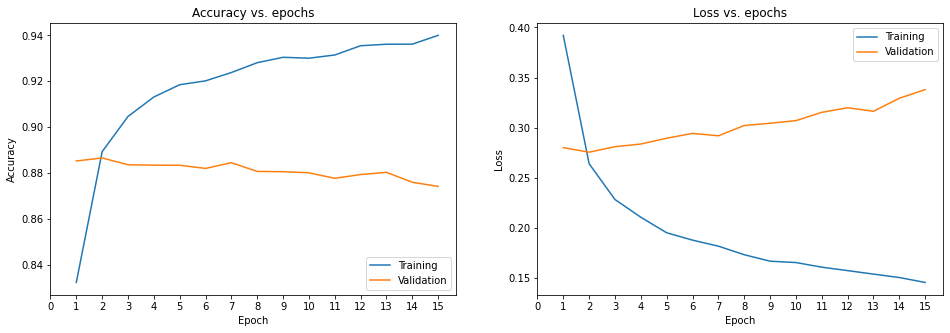

2021-07-21 05:17:26,184: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/mlp1
----------------------------------------evaluate----------------------------------------


2021-07-21 05:17:55,460: INFO: test loss:0.2756
2021-07-21 05:17:55,461: INFO: test accuracy:0.8866
2021-07-21 05:17:55,462: INFO: test sparse_top_k_categorical_accuracy:1.0000
2021-07-21 05:17:55,463: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/results.json
2021-07-21 05:17:55,464: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/results.json
2021-07-21 05:17:55,465: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/ngram_preproess.generator


----------------------------------------save model results and generator----------------------------------------


2021-07-21 05:17:56,023: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/ngram_preproess.generator


----------------------------------------confusion matrix----------------------------------------


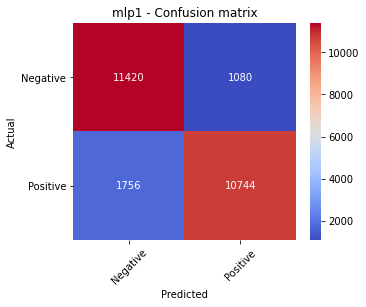

----------------------------------------sample analysis----------------------------------------
----------------------------------------1. Positive----------------------------------------
The fact that reviewers feel very intensely negative towards the show is an interesting fact all its own. If you dislike it so much, don't watch it.<br /><br />Certain reviewers assert that you have to be dumb, dim-witted, or plain old primitive to enjoy this show. Au contraire, my friends. I am not claiming that all the contestants are smart. There are smart ones, and there are dumb ones. But I WOULD argue that they probably have a higher average IQ than the average reviewer on this website. Thats right, I said it. There is a lot to be said for the science of seducing girls. I'm sorry, but please withdraw all sticks out of your asses, and realize the reason you hate these guys is that they threaten you.<br /><br />Those oblivious to social sciences, and more specifically, the science behind mating ar

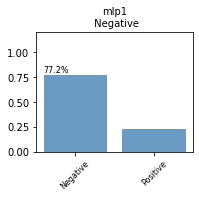

----------------------------------------2. Positive----------------------------------------
I generally love SRK as a villain (how can you not?) and I believe that SRK and Juhi are a perfect match on screen as they both are actually more nice than pretty.<br /><br />This movie is great to watch, although it has some major flaws: <br /><br />1) the good guy (Sunny) - not only he's so much less attractive than Shahrukh(what in my opinion is soooooo important in Bollyfilms) but his role lacks character - it would be much better if there was a conflict between two strong personalities, instead we have a conflict between a personality and an average soldier <br /><br />2) Kiran's and Sunil's reactions for Rahul's actions are unbelievably silly and naive even for a Bollywood production <br /><br />But all this is not that important in comparison with the wonderful melodramatic atmosphere, great songs (really truly great)and (let's say it again) Shahrukh as a villain, I just love him when he'

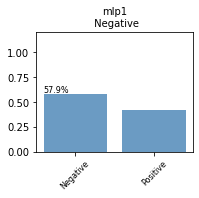

----------------------------------------3. Negative----------------------------------------
I'm going to make this short and sweet. It's not surprising that you had no use for this film. This is a story about the power, beauty and possibilities inherent in a meaningful education. Based on your pathetically composed comments I can see that your own education has been woefully neglected... or worse... completely wasted. Your comments are those of a truly ignorant person. I would advise you to do something about this condition... but in your case I feel it's probably too late. My hope is that you yourself don't intend to go into the teaching profession ( especially in Film Studies) because you could only do damage. Oh... one last bit of advice. In the future, if you intend to write more opinion pieces, you should really proofread your work. It will make people take you more seriously.


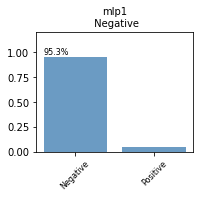

----------------------------------------4. Positive----------------------------------------
i love this film!! maybe it is my generation but i can really connect with what he is talking about and means to do. it kept me laughing for the duration. duration of the film, the next day, and beyond. i think this film is not one to watch if you mainly care about the plot and character development. this film is pretty much only for the generation that will understand it. there are lots of things you just know being brought up in that generation that you wouldn't if you were say 40. i think Sacha barren Cohen was Very and i do mean Very good. he is a genius. and the reason h is such an idiot is because he can make people believe he is a complete idiot, and make it funny at the same time!!<br /><br />Very good film. strongly recommend!!!! (not so strongly if you are over 30)


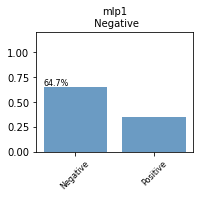

----------------------------------------5. Positive----------------------------------------
I honestly thought this movie was going to be cheesy, even though I've liked Alvin and the Chipmunks for a LONG TIME! I was was very wrong. IT WAS GREAT!!! It has been the best movie I have seen since October! In my opinion, it's the movie everyone should see this holiday season! Enchanted (I thought anyway...)was awful, The Golden Compass was alright, but the ending was pretty crappy to His Dark Materials fans, and I Am Legend, well I haven't seen that yet (or National Treasures 2) but it looks alright.<br /><br />I'm not about to give anything away, but this movie is great for anyone, especially kids!


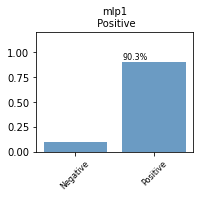

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_top2_accuracy,test_top2_accuracy,train_auc,test_auc
1,mlp1,5120770,59.4,0.1378,0.2756,0.9544,0.8866,1.0,1.0,0.9912,0.9559


In [28]:
helper = qtf.classification.Classification(params, datasets=ngram_datasets1, model_results=model_results)
model = qtf.classification.models.mlp1(helper, name='mlp1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True)

#### mlp2

2021-07-21 05:20:38,024: INFO: model_params.mlp2.dropout=0.6
2021-07-21 05:20:38,027: INFO: model_params.mlp2.layer_count=1
2021-07-21 05:20:38,028: INFO: model_params.mlp2.units=256
2021-07-21 05:20:38,049: INFO: output_bias=[-0.69314718 -0.69314718]
2021-07-21 05:20:38,057: INFO: learning_rate=0.001
2021-07-21 05:20:38,058: INFO: model_params.mlp2.clip_value=None
2021-07-21 05:20:38,063: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/mlp2
2021-07-21 05:20:38,066: INFO: model_params.mlp2.epochs=15
2021-07-21 05:20:38,066: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/mlp2, monitor=val_accuracy)
2021-07-21 05:20:38,067: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-07-21 05:20:38,067: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-07-21 05:20:38,068: INFO: use LearningRateScheduler()
2021-0

TensorSpec(shape=(32, 20000), dtype=tf.float32, name=None)
Model: "mlp2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20000)]           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 20000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               5120256   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 5,120,770
Trainable params: 5,120,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
781/781 [==============================] - 38s 4

2021-07-21 05:21:16,672: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/mlp2/assets


Epoch 2/15
781/781 [==============================] - 3s 4ms/step - loss: 0.3934 - accuracy: 0.8395 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.3279 - val_accuracy: 0.8836 - val_sparse_top_k_categorical_accuracy: 1.0000
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/mlp2/assets


2021-07-21 05:21:20,644: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/mlp2/assets


Epoch 3/15
781/781 [==============================] - 5s 6ms/step - loss: 0.3544 - accuracy: 0.8543 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.3037 - val_accuracy: 0.8885 - val_sparse_top_k_categorical_accuracy: 1.0000
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/mlp2/assets


2021-07-21 05:21:26,047: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/mlp2/assets


Epoch 4/15
781/781 [==============================] - 10s 13ms/step - loss: 0.3282 - accuracy: 0.8664 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.2968 - val_accuracy: 0.8843 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 5/15
781/781 [==============================] - 10s 13ms/step - loss: 0.3056 - accuracy: 0.8772 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.2880 - val_accuracy: 0.8886 - val_sparse_top_k_categorical_accuracy: 1.0000
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/mlp2/assets


2021-07-21 05:21:46,578: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/mlp2/assets


Epoch 6/15
781/781 [==============================] - 10s 13ms/step - loss: 0.3023 - accuracy: 0.8782 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.2839 - val_accuracy: 0.8880 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 7/15
781/781 [==============================] - 10s 13ms/step - loss: 0.2945 - accuracy: 0.8830 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.2839 - val_accuracy: 0.8920 - val_sparse_top_k_categorical_accuracy: 1.0000
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/mlp2/assets


2021-07-21 05:22:07,391: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/mlp2/assets


Epoch 8/15
781/781 [==============================] - 10s 12ms/step - loss: 0.2759 - accuracy: 0.8907 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.2681 - val_accuracy: 0.8942 - val_sparse_top_k_categorical_accuracy: 1.0000
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/mlp2/assets


2021-07-21 05:22:17,879: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/mlp2/assets


Epoch 9/15
781/781 [==============================] - 10s 13ms/step - loss: 0.2808 - accuracy: 0.8888 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.2679 - val_accuracy: 0.8938 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 10/15
781/781 [==============================] - 10s 13ms/step - loss: 0.2682 - accuracy: 0.8931 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.2742 - val_accuracy: 0.8930 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 11/15
781/781 [==============================] - 10s 13ms/step - loss: 0.2676 - accuracy: 0.8938 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.2782 - val_accuracy: 0.8947 - val_sparse_top_k_categorical_accuracy: 1.0000
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/mlp2/assets


2021-07-21 05:22:48,493: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/mlp2/assets


Epoch 12/15
781/781 [==============================] - 10s 13ms/step - loss: 0.2607 - accuracy: 0.8982 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.2724 - val_accuracy: 0.8932 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 13/15
781/781 [==============================] - 10s 13ms/step - loss: 0.2471 - accuracy: 0.9045 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.2639 - val_accuracy: 0.8960 - val_sparse_top_k_categorical_accuracy: 1.0000
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/mlp2/assets


2021-07-21 05:23:09,162: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/mlp2/assets


Epoch 14/15
781/781 [==============================] - 10s 13ms/step - loss: 0.2445 - accuracy: 0.9062 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.2655 - val_accuracy: 0.8954 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 15/15
781/781 [==============================] - 10s 13ms/step - loss: 0.2464 - accuracy: 0.9075 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.2720 - val_accuracy: 0.8942 - val_sparse_top_k_categorical_accuracy: 1.0000


2021-07-21 05:23:29,420: INFO: finish training [elapsed time: 171.35 seconds]


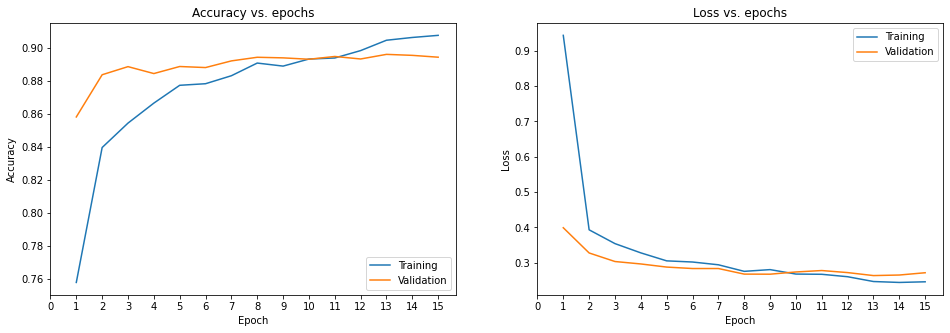

2021-07-21 05:23:29,935: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/mlp2


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/mlp2
----------------------------------------evaluate----------------------------------------


2021-07-21 05:24:11,951: INFO: test loss:0.2639
2021-07-21 05:24:11,952: INFO: test accuracy:0.8960
2021-07-21 05:24:11,952: INFO: test sparse_top_k_categorical_accuracy:1.0000
2021-07-21 05:24:11,954: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/results.json
2021-07-21 05:24:11,955: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/results.json
2021-07-21 05:24:11,956: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/ngram_map.generator


----------------------------------------save model results and generator----------------------------------------


2021-07-21 05:24:11,960: WARNING: Please add `keras.layers.InputLayer` instead of `keras.Input` to Sequential model. `keras.Input` is intended to be used by Functional model.


2021-07-21 05:24:12,001: WARNING: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/ngram_map.layer/assets


2021-07-21 05:24:12,813: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/ngram_map.layer/assets
2021-07-21 05:24:12,839: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/ngram_map.generator
2021-07-21 05:24:12,840: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/mlp1


----------------------------------------confusion matrix----------------------------------------


2021-07-21 05:24:13,232: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/ngram_preproess.generator


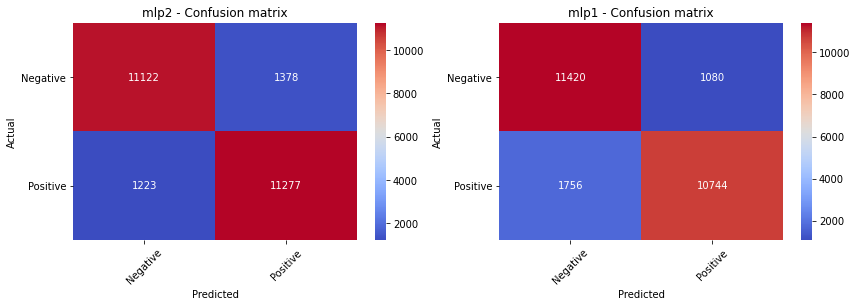

2021-07-21 05:24:47,458: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/mlp1


----------------------------------------sample analysis----------------------------------------


2021-07-21 05:24:47,843: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/ngram_preproess.generator


----------------------------------------1. Positive----------------------------------------
Two city guys are driving through Hicksville USA when a rusty monster truck suddenly appears and repeatedly attempts to run them off the road.Having picked up a mysterious blonde hitchhiker,they pull up at a truck-stop full of redneck amputees,one of whom warns them of 'the demon out there'. But they don't listen.Big mistake!"Monster Man" by Michael Davis mixes comedy with horror surprisingly well.The film borrows heavily from "Duel","The Blair Witch Project","Jeepers Creepers" and "The Texas Chainsaw Massacre".The story is pretty silly,but there is enough gore and violence to keep splatter freaks happy.I enjoyed especially the performance of Justin Urich,which offers the film its comedy relief.Still the complete lack of suspense is hard to forgive.Give this one a chance,if you have some time to waste.7 out of 10.Did I mention that Aimee Brooks is sexy?


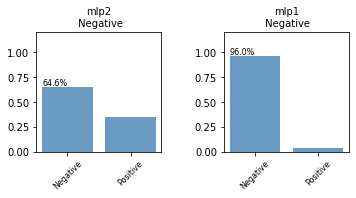

----------------------------------------2. Positive----------------------------------------
After watching "Waco: The Rules of Engagement" I was just sitting in disbelief of what I was witness to. A big cover up by the FBI, a massacre by gung-ho/trigger happy government agents? I clearly remember the Waco standoff, I was 17 years old at the time and watched it all on CNN. I remembered reflecting about all the children as I watched the Mount Camel compound burn in April 1993. I remember feeling sorry for the children, but clearly felt that it was the fault of their evil leader David Koresh and the other Davidians. Gazecki's film shows clearly and beyond doubt, even though it is biased, that the FBI lied over and over again. I think that this film was a big contributor to the reopening of a new investigation of the incident in 1999. The outcome of this new investigation was in some sense predictable, the judgement relied on fact that was just as grey as the facts that the Davidians prese

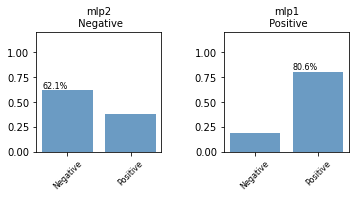

----------------------------------------3. Positive----------------------------------------
In 1968 when, "SYMBIOPSYCHOTAXIPLASM: Take One", was released, it came from out of nowhere, and struck like a psychedelic thunder bolt. Afro-American actor and film maker, William Greaves, aimed to forever alter the 'news-reel' style of documentary film-making, and to this day, there has never been anything quite like it. The movie is a film about 'the making of a film', and intentionally written and directed so as to create as much controversy and contradiction as possible. Set in New York's Central Park, the action and scant dialog concern a couple who fight and bicker about homosexuality and abortion. The woman wants out of the relationship, and the man wants an explanation. Near the end of this interaction, a drunk homeless man interrupts the proceedings and offers his commentary, and personal back-story. Then, after the principle footage has been shot, the film crew add their own views of t

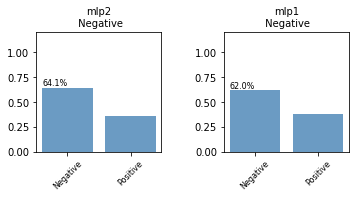

----------------------------------------4. Positive----------------------------------------
Shame on you if you give this film a low rating. How can you not like a film that has Doug McClure, Peter Cushing, silly rubber monsters, fights, (and for the guys, that woman that was the baddie's henchwoman in The Spy Who Loved Me and one of the seventies Sinbad films, not wearing very much of whom my mother said "She wasn't picked for the colour of her eyes"), lava, silly wigs and a daft Victorian drilling machine very much like the one used in the old Thunderbirds series? Whoever watched this film and slagged it off was watching it for the wrong reasons. It may be crap, but is definitely good crap. They don't make 'em like they used to, sigh......


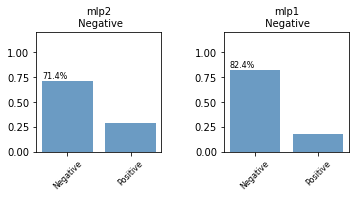

----------------------------------------5. Positive----------------------------------------
This is a well done action movie. There are plenty of fight scenes, the acting is convincing (for this genre) and RS1 is awesome. I don't know why people feel compelled to trash RS1, I thought his effects were executed very nicely and his design looked great. The plot was acceptable for a martial arts movie.<br /><br />Having said that, I must tell you Richard Sun is one of the worst actors from Hong Kong I have ever watched. At least RS1 had the right idea by killing him. Now, for all of you who thought Sam Lee (Alien) was a bad actor...he wasn't meant to be taken seriously! I have just had the pleasure of watching Gen-X Cops (prequel) and Sam Lee played the same character the same way!<br /><br />Now, please, all of you guys who watch highly reviewed Oscar winners: DO NOT JUDGE THIS IS A THINKING MAN'S MOVIE! IT ISN'T SUPPOSED TO REQUIRE THOUGHT! Just meant to be enjoyed, that's all. I hope th

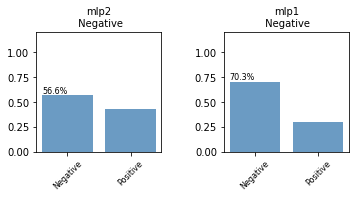

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_top2_accuracy,test_top2_accuracy,train_auc,test_auc
1,mlp2,5120770,170.9,0.1106,0.2639,0.9741,0.8960,1.0,1.0,0.9972,0.9591
2,mlp1,5120770,59.4,0.1378,0.2756,0.9544,0.8866,1.0,1.0,0.9912,0.9559


In [29]:
helper = qtf.classification.Classification(params, datasets=ngram_datasets2, model_results=model_results)
model = qtf.classification.models.mlp1(helper, name='mlp2')
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

### Embedding

#### embedding1

2021-07-21 05:25:47,581: INFO: model_params.embedding1.dropout=0.4
2021-07-21 05:25:47,582: INFO: model_params.embedding1.embedding_dim=200
2021-07-21 05:25:47,617: INFO: output_bias=[-0.69314718 -0.69314718]
2021-07-21 05:25:47,627: INFO: learning_rate=0.001
2021-07-21 05:25:47,628: INFO: model_params.embedding1.clip_value=None
2021-07-21 05:25:47,633: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/embedding1
2021-07-21 05:25:47,636: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/embedding1, monitor=val_accuracy)
2021-07-21 05:25:47,637: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-07-21 05:25:47,637: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-07-21 05:25:47,638: INFO: use LearningRateScheduler()
2021-07-21 05:25:47,638: INFO: start training
2021-07-21 05:25:47,639: INFO: use_class_wei

TensorSpec(shape=(32, 500), dtype=tf.int32, name=None)
Model: "embedding1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 200)     4000000     input_4[0][0]                    
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 200)          0           embedding[0][0]                  
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 200)          0           embedding[0][0]                  
__________________________________

2021-07-21 05:26:17,862: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/embedding1/assets


Epoch 2/10
781/781 [==============================] - 29s 37ms/step - loss: 0.2279 - accuracy: 0.9124 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.2744 - val_accuracy: 0.8859 - val_sparse_top_k_categorical_accuracy: 1.0000
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/embedding1/assets


2021-07-21 05:26:47,659: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/embedding1/assets


Epoch 3/10
781/781 [==============================] - 29s 37ms/step - loss: 0.1458 - accuracy: 0.9505 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.2793 - val_accuracy: 0.8840 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 4/10
781/781 [==============================] - 29s 37ms/step - loss: 0.0896 - accuracy: 0.9744 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.3026 - val_accuracy: 0.8782 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 5/10
781/781 [==============================] - 29s 38ms/step - loss: 0.0523 - accuracy: 0.9872 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.3344 - val_accuracy: 0.8723 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 6/10
781/781 [==============================] - 29s 37ms/step - loss: 0.0288 - accuracy: 0.9951 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.3690 - val_accuracy: 0.8680 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 7/10
781/781 [==============================] - 29

2021-07-21 05:30:25,408: INFO: finish training [elapsed time: 277.77 seconds]


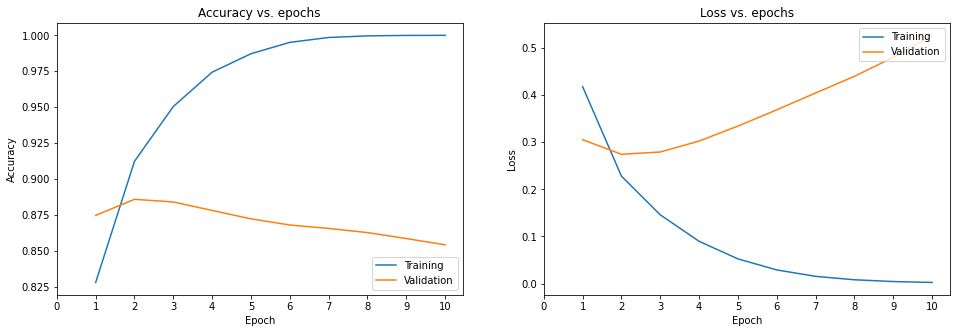

2021-07-21 05:30:25,834: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/embedding1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/embedding1
----------------------------------------evaluate----------------------------------------


2021-07-21 05:31:03,648: INFO: test loss:0.2744
2021-07-21 05:31:03,649: INFO: test accuracy:0.8859
2021-07-21 05:31:03,650: INFO: test sparse_top_k_categorical_accuracy:1.0000
2021-07-21 05:31:03,651: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/results.json
2021-07-21 05:31:03,652: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/results.json
2021-07-21 05:31:03,653: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sequence_prepross.generator
2021-07-21 05:31:03,726: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sequence_prepross.generator
2021-07-21 05:31:03,727: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/mlp2


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-07-21 05:31:04,067: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/ngram_map.generator


2021-07-21 05:31:04,362: WARNING: No training configuration found in save file, so the model was *not* compiled. Compile it manually.


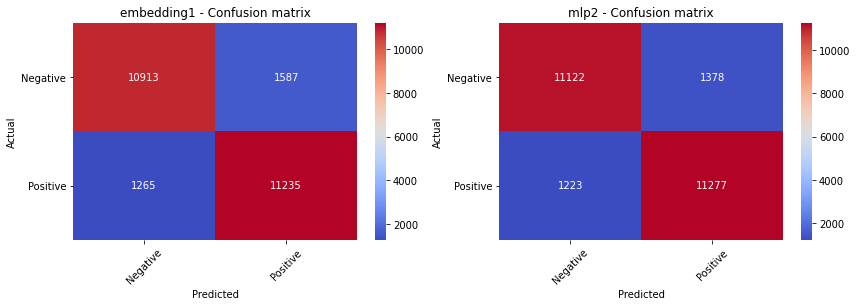

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_top2_accuracy,test_top2_accuracy,train_auc,test_auc
1,mlp2,5120770,170.9,0.1106,0.2639,0.9741,0.8960,1.0,1.0,0.9972,0.9591
2,mlp1,5120770,59.4,0.1378,0.2756,0.9544,0.8866,1.0,1.0,0.9912,0.9559
3,embedding1,4000802,277.3,0.1530,0.2744,0.9501,0.8859,1.0,1.0,0.9888,0.9543


In [31]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets1)
model = qtf.classification.models.embedding1(helper, name='embedding1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

#### embedding2

2021-07-21 05:37:45,016: INFO: model_params.embedding2.dropout=0.4
2021-07-21 05:37:45,017: INFO: model_params.embedding2.embedding_dim=200
2021-07-21 05:37:45,046: INFO: output_bias=[-0.69314718 -0.69314718]
2021-07-21 05:37:45,054: INFO: learning_rate=0.001
2021-07-21 05:37:45,055: INFO: model_params.embedding2.clip_value=None
2021-07-21 05:37:45,061: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/embedding2
2021-07-21 05:37:45,063: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/embedding2, monitor=val_accuracy)
2021-07-21 05:37:45,064: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-07-21 05:37:45,064: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-07-21 05:37:45,065: INFO: use LearningRateScheduler()
2021-07-21 05:37:45,065: INFO: start training
2021-07-21 05:37:45,066: INFO: use_class_wei

TensorSpec(shape=(32, 500), dtype=tf.int64, name=None)
Model: "embedding2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 500, 200)     4000000     input_5[0][0]                    
__________________________________________________________________________________________________
global_average_pooling1d_1 (Glo (None, 200)          0           embedding_1[0][0]                
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 200)          0           embedding_1[0][0]                
__________________________________

2021-07-21 05:38:15,335: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/embedding2/assets


Epoch 2/10
781/781 [==============================] - 21s 27ms/step - loss: 0.2299 - accuracy: 0.9104 - val_loss: 0.2801 - val_accuracy: 0.8830
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/embedding2/assets


2021-07-21 05:38:37,685: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/embedding2/assets


Epoch 3/10
781/781 [==============================] - 22s 29ms/step - loss: 0.1463 - accuracy: 0.9503 - val_loss: 0.2884 - val_accuracy: 0.8802
Epoch 4/10
781/781 [==============================] - 25s 32ms/step - loss: 0.0895 - accuracy: 0.9744 - val_loss: 0.3104 - val_accuracy: 0.8751
Epoch 5/10
781/781 [==============================] - 21s 27ms/step - loss: 0.0523 - accuracy: 0.9880 - val_loss: 0.3405 - val_accuracy: 0.8695
Epoch 6/10
781/781 [==============================] - 24s 30ms/step - loss: 0.0291 - accuracy: 0.9956 - val_loss: 0.3740 - val_accuracy: 0.8652
Epoch 7/10
781/781 [==============================] - 23s 29ms/step - loss: 0.0155 - accuracy: 0.9984 - val_loss: 0.4093 - val_accuracy: 0.8617
Epoch 8/10
781/781 [==============================] - 20s 26ms/step - loss: 0.0081 - accuracy: 0.9996 - val_loss: 0.4453 - val_accuracy: 0.8592
Epoch 9/10
781/781 [==============================] - 26s 34ms/step - loss: 0.0043 - accuracy: 0.9999 - val_loss: 0.4773 - val_accuracy:

2021-07-21 05:41:37,473: INFO: finish training [elapsed time: 232.41 seconds]


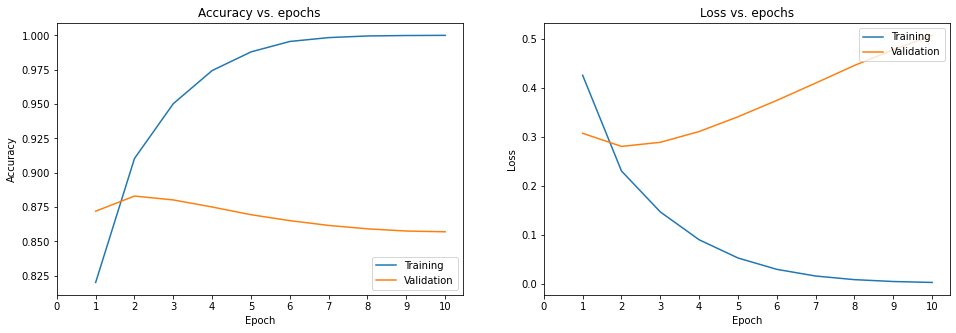

2021-07-21 05:41:37,859: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/embedding2


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/embedding2
----------------------------------------evaluate----------------------------------------


2021-07-21 05:42:10,115: INFO: test loss:0.2801
2021-07-21 05:42:10,116: INFO: test accuracy:0.8830
2021-07-21 05:42:10,117: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/results.json
2021-07-21 05:42:10,119: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/results.json
2021-07-21 05:42:10,119: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sequence_map.generator


----------------------------------------save model results and generator----------------------------------------


2021-07-21 05:42:10,123: WARNING: Please add `keras.layers.InputLayer` instead of `keras.Input` to Sequential model. `keras.Input` is intended to be used by Functional model.


2021-07-21 05:42:10,162: WARNING: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sequence_map.layer/assets


2021-07-21 05:42:10,700: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sequence_map.layer/assets
2021-07-21 05:42:10,721: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sequence_map.generator
2021-07-21 05:42:10,721: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/mlp2


----------------------------------------confusion matrix----------------------------------------


2021-07-21 05:42:11,023: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/ngram_map.generator


2021-07-21 05:42:11,314: WARNING: No training configuration found in save file, so the model was *not* compiled. Compile it manually.


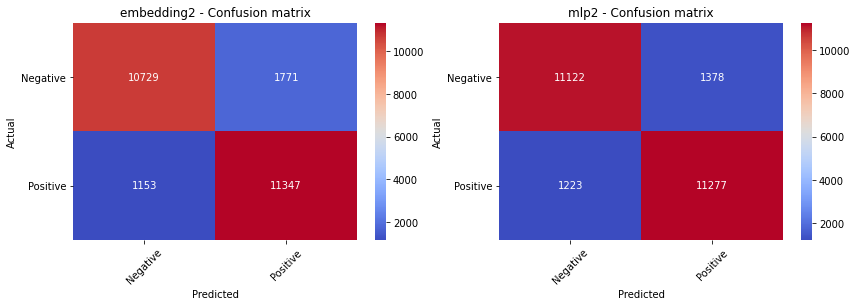

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_top2_accuracy,test_top2_accuracy,train_auc,test_auc
1,mlp2,5120770,170.9,0.1106,0.2639,0.9741,0.8960,1.0,1.0,0.9972,0.9591
2,mlp1,5120770,59.4,0.1378,0.2756,0.9544,0.8866,1.0,1.0,0.9912,0.9559
3,embedding1,4000802,277.3,0.1530,0.2744,0.9501,0.8859,1.0,1.0,0.9888,0.9543
4,embedding2,4000802,231.9,0.1556,0.2801,0.9484,0.8830,NaN,NaN,0.9893,0.9532


In [33]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.models.embedding1(helper, name='embedding2')
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

### sepCNN

#### sepcnn

2021-07-21 05:45:42,694: INFO: model_params.sepcnn.dropout=0.4
2021-07-21 05:45:42,756: INFO: output_bias=[-0.69314718 -0.69314718]
2021-07-21 05:45:42,762: INFO: learning_rate=0.001
2021-07-21 05:45:42,762: INFO: model_params.sepcnn.clip_value=None
2021-07-21 05:45:42,768: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sepcnn
2021-07-21 05:45:42,771: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sepcnn, monitor=val_accuracy)
2021-07-21 05:45:42,772: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-07-21 05:45:42,772: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-07-21 05:45:42,773: INFO: use LearningRateScheduler()
2021-07-21 05:45:42,774: INFO: start training
2021-07-21 05:45:42,774: INFO: use_class_weight=False


TensorSpec(shape=(32, 500), dtype=tf.int64, name=None)
Model: "sepcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 200)          4000200   
_________________________________________________________________
dropout_8 (Dropout)          (None, 500, 200)          0         
_________________________________________________________________
separable_conv1d_4 (Separabl (None, 500, 128)          26328     
_________________________________________________________________
separable_conv1d_5 (Separabl (None, 500, 128)          16896     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 166, 128)          0         
_________________________________________________________________
global_average_pooling1d_4 ( (None, 128)               0         
_________________________________________________________________
dropo

2021-07-21 05:46:13,272: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sepcnn/assets


Epoch 2/10
781/781 [==============================] - 24s 31ms/step - loss: 0.3125 - accuracy: 0.8757 - val_loss: 0.2756 - val_accuracy: 0.8909
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sepcnn/assets


2021-07-21 05:46:38,677: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sepcnn/assets


Epoch 3/10
781/781 [==============================] - 22s 29ms/step - loss: 0.1868 - accuracy: 0.9298 - val_loss: 0.2940 - val_accuracy: 0.8906
Epoch 4/10
781/781 [==============================] - 23s 29ms/step - loss: 0.1222 - accuracy: 0.9561 - val_loss: 0.3580 - val_accuracy: 0.8814
Epoch 5/10
781/781 [==============================] - 22s 29ms/step - loss: 0.0807 - accuracy: 0.9710 - val_loss: 0.4332 - val_accuracy: 0.8710
Epoch 6/10
781/781 [==============================] - 22s 29ms/step - loss: 0.0541 - accuracy: 0.9819 - val_loss: 0.5220 - val_accuracy: 0.8689
Epoch 7/10
781/781 [==============================] - 22s 29ms/step - loss: 0.0391 - accuracy: 0.9871 - val_loss: 0.6111 - val_accuracy: 0.8665
Epoch 8/10
781/781 [==============================] - 30s 38ms/step - loss: 0.0329 - accuracy: 0.9899 - val_loss: 0.6874 - val_accuracy: 0.8599
Epoch 9/10
781/781 [==============================] - 28s 36ms/step - loss: 0.0275 - accuracy: 0.9916 - val_loss: 0.7594 - val_accuracy:

2021-07-21 05:49:55,260: INFO: finish training [elapsed time: 252.49 seconds]


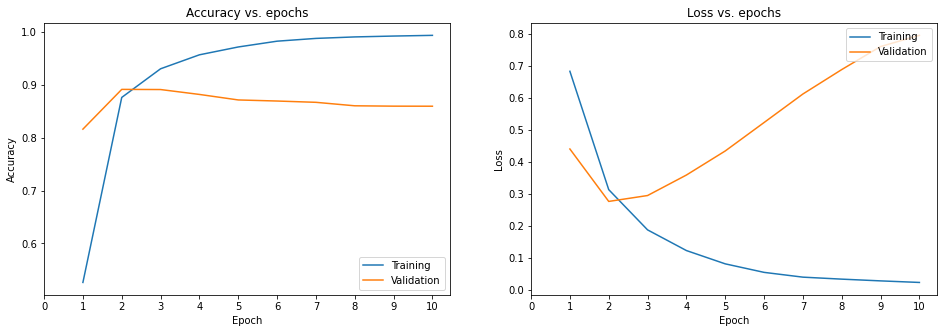

2021-07-21 05:49:55,654: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sepcnn


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sepcnn
----------------------------------------evaluate----------------------------------------


2021-07-21 05:50:28,806: INFO: test loss:0.2756
2021-07-21 05:50:28,807: INFO: test accuracy:0.8909
2021-07-21 05:50:28,808: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/results.json
2021-07-21 05:50:28,810: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/results.json
2021-07-21 05:50:28,810: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sequence_map.generator


----------------------------------------save model results and generator----------------------------------------


2021-07-21 05:50:28,815: WARNING: Please add `keras.layers.InputLayer` instead of `keras.Input` to Sequential model. `keras.Input` is intended to be used by Functional model.


2021-07-21 05:50:28,857: WARNING: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sequence_map.layer/assets


2021-07-21 05:50:29,436: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sequence_map.layer/assets
2021-07-21 05:50:29,457: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sequence_map.generator
2021-07-21 05:50:29,458: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/mlp2


----------------------------------------confusion matrix----------------------------------------


2021-07-21 05:50:29,785: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/ngram_map.generator


2021-07-21 05:50:30,568: WARNING: No training configuration found in save file, so the model was *not* compiled. Compile it manually.


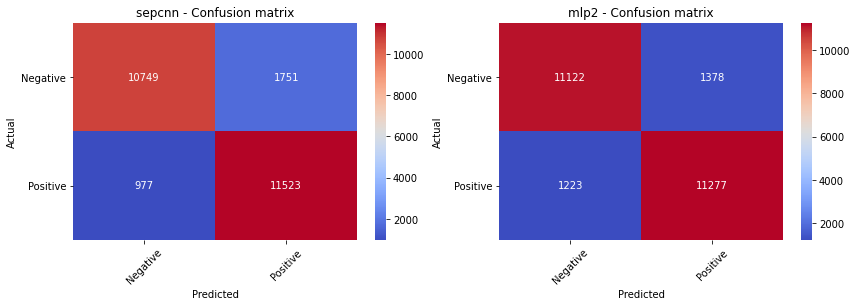

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_top2_accuracy,test_top2_accuracy,train_auc,test_auc
1,mlp2,5120770,170.9,0.1106,0.2639,0.9741,0.8960,1.0,1.0,0.9972,0.9591
2,sepcnn,4043682,252.0,0.1779,0.2756,0.9349,0.8909,NaN,NaN,0.9832,0.9557
3,mlp1,5120770,59.4,0.1378,0.2756,0.9544,0.8866,1.0,1.0,0.9912,0.9559
4,embedding1,4000802,277.3,0.1530,0.2744,0.9501,0.8859,1.0,1.0,0.9888,0.9543
5,embedding2,4000802,231.9,0.1556,0.2801,0.9484,0.8830,NaN,NaN,0.9893,0.9532


In [36]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.models.sepcnn1(helper, name='sepcnn', blocks=1)
# when bolcks=2, the model can't converg
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

#### sepcnn_fasttext

2021-07-21 05:50:56,176: INFO: model_params.sepcnn_fasttext.dropout=0.4


TensorSpec(shape=(32, 500), dtype=tf.int64, name=None)


2021-07-21 05:50:56,305: INFO: output_bias=[-0.69314718 -0.69314718]
2021-07-21 05:50:56,313: INFO: learning_rate=0.001
2021-07-21 05:50:56,313: INFO: model_params.sepcnn_fasttext.clip_value=None
2021-07-21 05:50:56,319: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sepcnn_fasttext
2021-07-21 05:50:56,324: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sepcnn_fasttext, monitor=val_accuracy)
2021-07-21 05:50:56,324: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-07-21 05:50:56,325: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-07-21 05:50:56,325: INFO: use LearningRateScheduler()
2021-07-21 05:50:56,326: INFO: start training
2021-07-21 05:50:56,327: INFO: use_class_weight=False


Model: "sepcnn_fasttext"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 300)          6000000   
_________________________________________________________________
dropout_10 (Dropout)         (None, 500, 300)          0         
_________________________________________________________________
separable_conv1d_6 (Separabl (None, 500, 64)           20164     
_________________________________________________________________
separable_conv1d_7 (Separabl (None, 500, 64)           4352      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 166, 64)           0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 166, 64)           0         
_________________________________________________________________
separable_conv1d_8 (Separabl (None, 166, 128)      

2021-07-21 05:51:22,425: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sepcnn_fasttext/assets


Epoch 2/20
781/781 [==============================] - 26s 33ms/step - loss: 0.6934 - accuracy: 0.4934 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 3/20
781/781 [==============================] - 17s 22ms/step - loss: 0.6933 - accuracy: 0.4961 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/20
781/781 [==============================] - 22s 28ms/step - loss: 0.6933 - accuracy: 0.4953 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/20
781/781 [==============================] - 26s 34ms/step - loss: 0.6932 - accuracy: 0.4966 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/20
781/781 [==============================] - 20s 25ms/step - loss: 0.6932 - accuracy: 0.5012 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/20
781/781 [==============================] - 20s 25ms/step - loss: 0.6932 - accuracy: 0.4976 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 8/20
781/781 [==============================] - 26s 34ms/step - loss: 0.6932 - accuracy: 0.4985 - val_loss: 0.6932 - val_accuracy:

2021-07-21 05:58:36,623: INFO: finish training [elapsed time: 460.30 seconds]


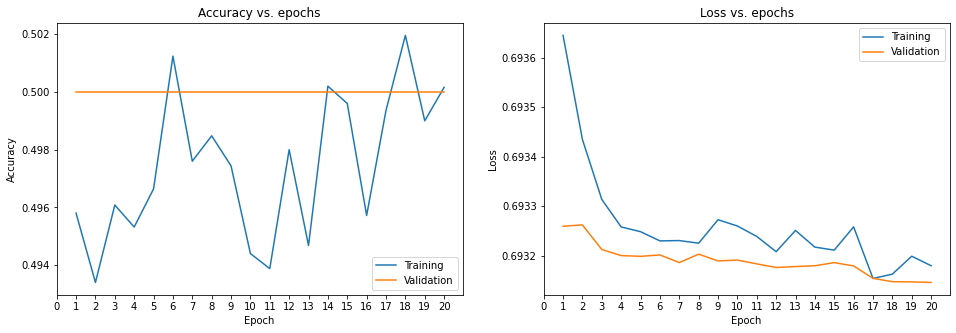

2021-07-21 05:58:37,177: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sepcnn_fasttext


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sepcnn_fasttext
----------------------------------------evaluate----------------------------------------


2021-07-21 05:59:12,998: INFO: test loss:0.6933
2021-07-21 05:59:12,999: INFO: test accuracy:0.5000
2021-07-21 05:59:13,001: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/results.json
2021-07-21 05:59:13,002: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/results.json
2021-07-21 05:59:13,003: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sequence_map.generator


----------------------------------------save model results and generator----------------------------------------


2021-07-21 05:59:13,008: WARNING: Please add `keras.layers.InputLayer` instead of `keras.Input` to Sequential model. `keras.Input` is intended to be used by Functional model.


2021-07-21 05:59:13,057: WARNING: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sequence_map.layer/assets


2021-07-21 05:59:13,704: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sequence_map.layer/assets
2021-07-21 05:59:13,732: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sequence_map.generator
2021-07-21 05:59:13,733: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/mlp2


----------------------------------------confusion matrix----------------------------------------


2021-07-21 05:59:14,118: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/ngram_map.generator


2021-07-21 05:59:14,924: WARNING: No training configuration found in save file, so the model was *not* compiled. Compile it manually.


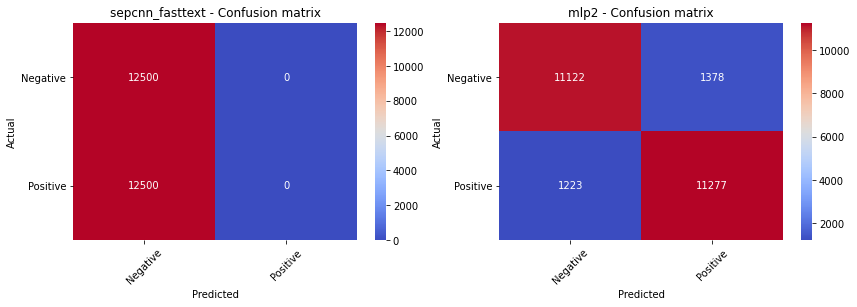

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_top2_accuracy,test_top2_accuracy,train_auc,test_auc
1,mlp2,5120770,170.9,0.1106,0.2639,0.9741,0.8960,1.0,1.0,0.9972,0.9591
2,sepcnn,4043682,252.0,0.1779,0.2756,0.9349,0.8909,NaN,NaN,0.9832,0.9557
3,mlp1,5120770,59.4,0.1378,0.2756,0.9544,0.8866,1.0,1.0,0.9912,0.9559
4,embedding1,4000802,277.3,0.1530,0.2744,0.9501,0.8859,1.0,1.0,0.9888,0.9543
5,embedding2,4000802,231.9,0.1556,0.2801,0.9484,0.8830,NaN,NaN,0.9893,0.9532
6,sepcnn_fasttext,50182,459.8,0.6933,0.6933,0.5000,0.5000,NaN,NaN,0.5090,0.5083


In [37]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.models.sepcnn1(helper, name='sepcnn_ft', blocks=1, 
                   embedding_matrix=embedding_matrix_fasttext,
                   is_embedding_trainable=False)
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

### LSTM

#### rnn_lstm

2021-07-21 06:32:41,561: INFO: model_params.rnn_lstm.dropout=0.4
2021-07-21 06:32:41,561: INFO: model_params.rnn_lstm.units=200
2021-07-21 06:32:41,562: INFO: max_features=20000
2021-07-21 06:32:41,562: INFO: model_params.rnn_lstm.embedding_dim=200


TensorSpec(shape=(32, 500), dtype=tf.int64, name=None)


2021-07-21 06:32:42,281: INFO: output_bias=[-0.69314718 -0.69314718]
2021-07-21 06:32:42,287: INFO: learning_rate=0.001
2021-07-21 06:32:42,288: INFO: model_params.rnn_lstm.clip_value=None
2021-07-21 06:32:42,293: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/rnn_lstm
2021-07-21 06:32:42,303: INFO: model_params.rnn_lstm.epochs=5
2021-07-21 06:32:42,303: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/rnn_lstm, monitor=val_accuracy)
2021-07-21 06:32:42,304: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-07-21 06:32:42,305: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-07-21 06:32:42,305: INFO: use LearningRateScheduler()
2021-07-21 06:32:42,306: INFO: start training
2021-07-21 06:32:42,306: INFO: use_class_weight=False


Model: "rnn_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 500)]             0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 500, 200)          4000200   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 500, 400)          641600    
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               480800    
_________________________________________________________________
dropout_14 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 402       
Total params: 5,123,002
Trainable params: 5,123,002
Non-trainable params: 0
________________________________________________

2021-07-21 06:34:44,089: WARNING: Found untraced functions such as lstm_cell_11_layer_call_and_return_conditional_losses, lstm_cell_11_layer_call_fn, lstm_cell_9_layer_call_and_return_conditional_losses, lstm_cell_9_layer_call_fn, lstm_cell_10_layer_call_and_return_conditional_losses while saving (showing 5 of 15). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/rnn_lstm/assets


2021-07-21 06:34:46,115: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/rnn_lstm/assets


Epoch 2/5
781/781 [==============================] - 105s 134ms/step - loss: 0.6966 - accuracy: 0.5058 - val_loss: 0.6942 - val_accuracy: 0.4919
Epoch 3/5
781/781 [==============================] - 105s 134ms/step - loss: 0.6884 - accuracy: 0.5170 - val_loss: 0.6947 - val_accuracy: 0.5057


2021-07-21 06:38:29,531: WARNING: Found untraced functions such as lstm_cell_11_layer_call_and_return_conditional_losses, lstm_cell_11_layer_call_fn, lstm_cell_9_layer_call_and_return_conditional_losses, lstm_cell_9_layer_call_fn, lstm_cell_10_layer_call_and_return_conditional_losses while saving (showing 5 of 15). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/rnn_lstm/assets


2021-07-21 06:38:31,555: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/rnn_lstm/assets


Epoch 4/5
781/781 [==============================] - 105s 134ms/step - loss: 0.6812 - accuracy: 0.5234 - val_loss: 0.6969 - val_accuracy: 0.5056
Epoch 5/5
781/781 [==============================] - 106s 136ms/step - loss: 0.6733 - accuracy: 0.5244 - val_loss: 0.6983 - val_accuracy: 0.5044


2021-07-21 06:42:03,221: INFO: finish training [elapsed time: 560.92 seconds]


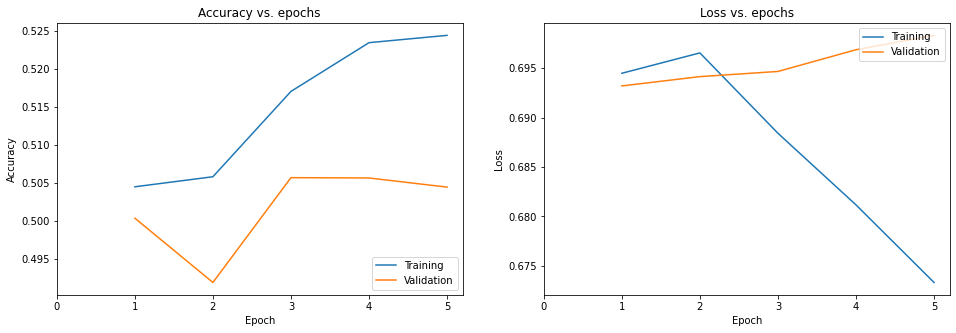

2021-07-21 06:42:03,643: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/rnn_lstm


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/rnn_lstm
----------------------------------------evaluate----------------------------------------


2021-07-21 06:43:56,563: INFO: test loss:0.6947
2021-07-21 06:43:56,564: INFO: test accuracy:0.5057
2021-07-21 06:43:56,565: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/results.json
2021-07-21 06:43:56,567: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/results.json
2021-07-21 06:43:56,567: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sequence_map.generator


----------------------------------------save model results and generator----------------------------------------


2021-07-21 06:43:56,572: WARNING: Please add `keras.layers.InputLayer` instead of `keras.Input` to Sequential model. `keras.Input` is intended to be used by Functional model.


2021-07-21 06:43:56,610: WARNING: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sequence_map.layer/assets


2021-07-21 06:43:57,149: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sequence_map.layer/assets
2021-07-21 06:43:57,170: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sequence_map.generator
2021-07-21 06:43:57,170: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/rnn_lstm_fasttext


----------------------------------------confusion matrix----------------------------------------


2021-07-21 06:44:05,105: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sequence_map.generator


2021-07-21 06:44:05,448: WARNING: No training configuration found in save file, so the model was *not* compiled. Compile it manually.


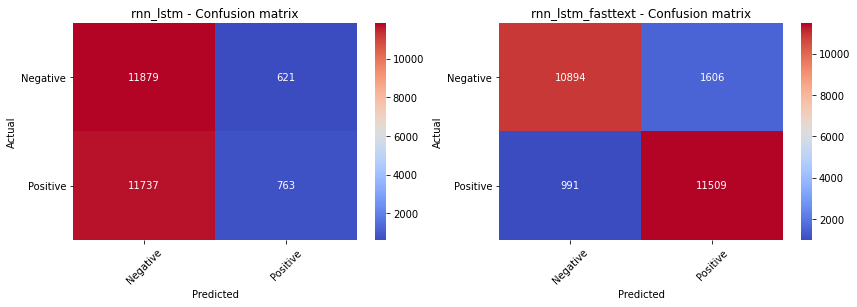

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc,train_top2_accuracy,test_top2_accuracy
1,rnn_lstm_fasttext,1282802,1487.2,0.2090,0.2680,0.9174,0.8961,0.9739,0.9592,NaN,NaN
2,mlp2,5120770,170.9,0.1106,0.2639,0.9741,0.8960,0.9972,0.9591,1.0,1.0
3,sepcnn,4043682,252.0,0.1779,0.2756,0.9349,0.8909,0.9832,0.9557,NaN,NaN
4,mlp1,5120770,59.4,0.1378,0.2756,0.9544,0.8866,0.9912,0.9559,1.0,1.0
5,embedding1,4000802,277.3,0.1530,0.2744,0.9501,0.8859,0.9888,0.9543,1.0,1.0
6,embedding2,4000802,231.9,0.1556,0.2801,0.9484,0.8830,0.9893,0.9532,NaN,NaN
7,rnn_lstm,5123002,560.4,0.6821,0.6947,0.5258,0.5057,0.5369,0.4975,NaN,NaN
8,sepcnn_fasttext,50182,459.8,0.6933,0.6933,0.5000,0.5000,0.5090,0.5083,NaN,NaN


In [41]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.models.lstm1(helper, name='rnn_lstm')
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

#### rnn_lstm_fasttext

2021-07-21 06:05:08,678: INFO: model_params.rnn_lstm_fasttext.dropout=0.4
2021-07-21 06:05:08,679: INFO: model_params.rnn_lstm_fasttext.units=200
2021-07-21 06:05:08,680: INFO: max_features=20000
2021-07-21 06:05:08,681: INFO: model_params.rnn_lstm_fasttext.embedding_dim=200


TensorSpec(shape=(32, 500), dtype=tf.int64, name=None)
20000 300
<class 'tensorflow.python.keras.engine.keras_tensor.KerasTensor'> 200


2021-07-21 06:05:09,784: INFO: output_bias=[-0.69314718 -0.69314718]
2021-07-21 06:05:09,798: INFO: learning_rate=0.001
2021-07-21 06:05:09,799: INFO: model_params.rnn_lstm_fasttext.clip_value=None
2021-07-21 06:05:09,812: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/rnn_lstm_fasttext
2021-07-21 06:05:09,815: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/rnn_lstm_fasttext, monitor=val_accuracy)
2021-07-21 06:05:09,816: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-07-21 06:05:09,817: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-07-21 06:05:09,817: INFO: use LearningRateScheduler()
2021-07-21 06:05:09,818: INFO: start training
2021-07-21 06:05:09,819: INFO: use_class_weight=False


Model: "rnn_lstm_fasttext"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 500, 300)          6000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 500, 400)          801600    
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               480800    
_________________________________________________________________
dropout_13 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 402       
Total params: 7,282,802
Trainable params: 1,282,802
Non-trainable params: 6,000,000
_______________________________

2021-07-21 06:07:57,377: WARNING: Found untraced functions such as lstm_cell_3_layer_call_and_return_conditional_losses, lstm_cell_3_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_2_layer_call_and_return_conditional_losses while saving (showing 5 of 15). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/rnn_lstm_fasttext/assets


2021-07-21 06:07:59,925: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/rnn_lstm_fasttext/assets


Epoch 2/10
781/781 [==============================] - 166s 213ms/step - loss: 0.6902 - accuracy: 0.5160 - val_loss: 0.6991 - val_accuracy: 0.5000
Epoch 3/10
781/781 [==============================] - 166s 213ms/step - loss: 0.6799 - accuracy: 0.5535 - val_loss: 0.6210 - val_accuracy: 0.6882


2021-07-21 06:13:51,726: WARNING: Found untraced functions such as lstm_cell_3_layer_call_and_return_conditional_losses, lstm_cell_3_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_2_layer_call_and_return_conditional_losses while saving (showing 5 of 15). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/rnn_lstm_fasttext/assets


2021-07-21 06:13:54,306: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/rnn_lstm_fasttext/assets


Epoch 4/10
781/781 [==============================] - 166s 212ms/step - loss: 0.6096 - accuracy: 0.6903 - val_loss: 0.6441 - val_accuracy: 0.6090
Epoch 5/10
781/781 [==============================] - 167s 214ms/step - loss: 0.6165 - accuracy: 0.6591 - val_loss: 0.5792 - val_accuracy: 0.7459


2021-07-21 06:19:46,293: WARNING: Found untraced functions such as lstm_cell_3_layer_call_and_return_conditional_losses, lstm_cell_3_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_2_layer_call_and_return_conditional_losses while saving (showing 5 of 15). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/rnn_lstm_fasttext/assets


2021-07-21 06:19:48,873: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/rnn_lstm_fasttext/assets


Epoch 6/10
781/781 [==============================] - 144s 184ms/step - loss: 0.6127 - accuracy: 0.6786 - val_loss: 0.5762 - val_accuracy: 0.7127
Epoch 7/10
781/781 [==============================] - 101s 130ms/step - loss: 0.6674 - accuracy: 0.5518 - val_loss: 0.6820 - val_accuracy: 0.5235
Epoch 8/10
781/781 [==============================] - 101s 130ms/step - loss: 0.4672 - accuracy: 0.7640 - val_loss: 0.2894 - val_accuracy: 0.8839


2021-07-21 06:25:48,915: WARNING: Found untraced functions such as lstm_cell_3_layer_call_and_return_conditional_losses, lstm_cell_3_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_2_layer_call_and_return_conditional_losses while saving (showing 5 of 15). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/rnn_lstm_fasttext/assets


2021-07-21 06:25:50,886: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/rnn_lstm_fasttext/assets


Epoch 9/10
781/781 [==============================] - 110s 141ms/step - loss: 0.2773 - accuracy: 0.8888 - val_loss: 0.2657 - val_accuracy: 0.8933


2021-07-21 06:27:56,892: WARNING: Found untraced functions such as lstm_cell_3_layer_call_and_return_conditional_losses, lstm_cell_3_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_2_layer_call_and_return_conditional_losses while saving (showing 5 of 15). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/rnn_lstm_fasttext/assets


2021-07-21 06:27:59,199: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/rnn_lstm_fasttext/assets


Epoch 10/10
781/781 [==============================] - 101s 130ms/step - loss: 0.2413 - accuracy: 0.9040 - val_loss: 0.2680 - val_accuracy: 0.8961


2021-07-21 06:29:54,503: WARNING: Found untraced functions such as lstm_cell_3_layer_call_and_return_conditional_losses, lstm_cell_3_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_2_layer_call_and_return_conditional_losses while saving (showing 5 of 15). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/rnn_lstm_fasttext/assets


2021-07-21 06:29:56,563: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/rnn_lstm_fasttext/assets
2021-07-21 06:29:57,508: INFO: finish training [elapsed time: 1487.69 seconds]


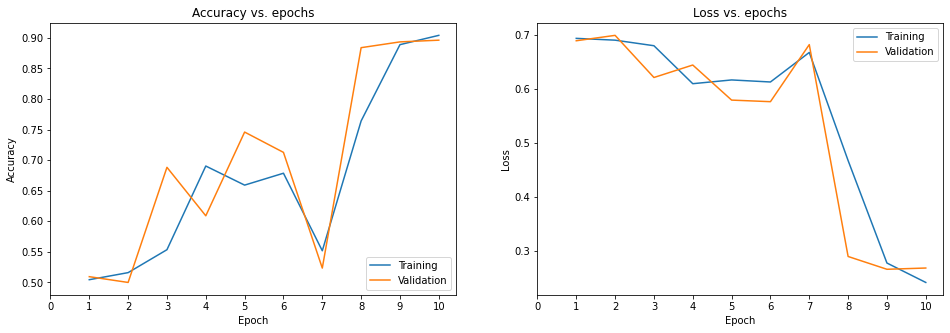

2021-07-21 06:29:57,905: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/rnn_lstm_fasttext


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/rnn_lstm_fasttext
----------------------------------------evaluate----------------------------------------


2021-07-21 06:31:58,828: INFO: test loss:0.2680
2021-07-21 06:31:58,828: INFO: test accuracy:0.8961
2021-07-21 06:31:58,830: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/results.json
2021-07-21 06:31:58,831: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/results.json
2021-07-21 06:31:58,832: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sequence_map.generator


----------------------------------------save model results and generator----------------------------------------


2021-07-21 06:31:58,836: WARNING: Please add `keras.layers.InputLayer` instead of `keras.Input` to Sequential model. `keras.Input` is intended to be used by Functional model.


2021-07-21 06:31:58,875: WARNING: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sequence_map.layer/assets


2021-07-21 06:31:59,386: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sequence_map.layer/assets
2021-07-21 06:31:59,405: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sequence_map.generator
2021-07-21 06:31:59,406: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/mlp2


----------------------------------------confusion matrix----------------------------------------


2021-07-21 06:31:59,688: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/ngram_map.generator


2021-07-21 06:31:59,960: WARNING: No training configuration found in save file, so the model was *not* compiled. Compile it manually.


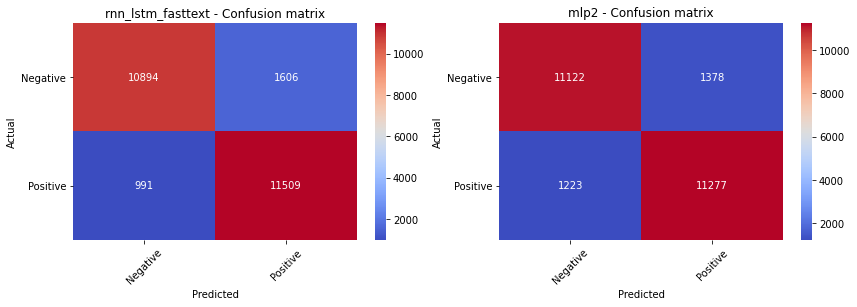

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc,train_top2_accuracy,test_top2_accuracy
1,rnn_lstm_fasttext,1282802,1487.2,0.2090,0.2680,0.9174,0.8961,0.9739,0.9592,NaN,NaN
2,mlp2,5120770,170.9,0.1106,0.2639,0.9741,0.8960,0.9972,0.9591,1.0,1.0
3,sepcnn,4043682,252.0,0.1779,0.2756,0.9349,0.8909,0.9832,0.9557,NaN,NaN
4,mlp1,5120770,59.4,0.1378,0.2756,0.9544,0.8866,0.9912,0.9559,1.0,1.0
5,embedding1,4000802,277.3,0.1530,0.2744,0.9501,0.8859,0.9888,0.9543,1.0,1.0
6,embedding2,4000802,231.9,0.1556,0.2801,0.9484,0.8830,0.9893,0.9532,NaN,NaN
7,sepcnn_fasttext,50182,459.8,0.6933,0.6933,0.5000,0.5000,0.5090,0.5083,NaN,NaN


In [40]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.models.lstm1(helper, name='rnn_lstm_ft',
                 embedding_matrix=embedding_matrix_fasttext,
                 is_embedding_trainable=False,
                 mask_zero=False)
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

### Pooled GRU 

#### pg_default

2021-07-21 06:44:59,695: INFO: model_params.pg_default.dropout=0.4
2021-07-21 06:44:59,696: INFO: model_params.pg_default.units=80
2021-07-21 06:44:59,697: INFO: max_features=20000
2021-07-21 06:44:59,697: INFO: model_params.pg_default.embedding_dim=300
2021-07-21 06:45:00,135: INFO: output_bias=[-0.69314718 -0.69314718]
2021-07-21 06:45:00,143: INFO: model_params.pg_default.learning_rate=0.0005
2021-07-21 06:45:00,144: INFO: model_params.pg_default.clip_value=None
2021-07-21 06:45:00,149: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/pg_default
2021-07-21 06:45:00,152: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/pg_default, monitor=val_accuracy)
2021-07-21 06:45:00,153: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-07-21 06:45:00,153: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-07-21

Model: "pg_default"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 500, 300)     6000000     input_13[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 500, 300)     0           embedding_8[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 500, 160)     183360      spatial_dropout1d[0][0]          
_________________________________________________________________________________________

2021-07-21 06:46:04,702: WARNING: Found untraced functions such as gru_cell_1_layer_call_and_return_conditional_losses, gru_cell_1_layer_call_fn, gru_cell_2_layer_call_and_return_conditional_losses, gru_cell_2_layer_call_fn, gru_cell_1_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/pg_default/assets


2021-07-21 06:46:06,732: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/pg_default/assets


Epoch 2/10
Epoch 00002: Still keep learning rate 0.0005 instead of 0.001
781/781 [==============================] - 53s 68ms/step - loss: 0.1879 - accuracy: 0.9280 - val_loss: 0.3510 - val_accuracy: 0.8666
Epoch 3/10
Epoch 00003: Still keep learning rate 0.0005 instead of 0.001
781/781 [==============================] - 53s 68ms/step - loss: 0.1086 - accuracy: 0.9631 - val_loss: 0.4894 - val_accuracy: 0.8555
Epoch 4/10
Epoch 00004: Still keep learning rate 0.0005 instead of 0.001
781/781 [==============================] - 53s 68ms/step - loss: 0.0752 - accuracy: 0.9752 - val_loss: 0.4865 - val_accuracy: 0.8598
Epoch 5/10
Epoch 00005: Still keep learning rate 0.0005 instead of 0.001
781/781 [==============================] - 53s 68ms/step - loss: 0.0499 - accuracy: 0.9829 - val_loss: 0.4715 - val_accuracy: 0.8604
Epoch 6/10
Epoch 00006: Still keep learning rate 0.0005 instead of 0.001
781/781 [==============================] - 53s 68ms/step - loss: 0.0289 - accuracy: 0.9906 - val_loss: 

2021-07-21 06:54:03,940: INFO: finish training [elapsed time: 543.79 seconds]


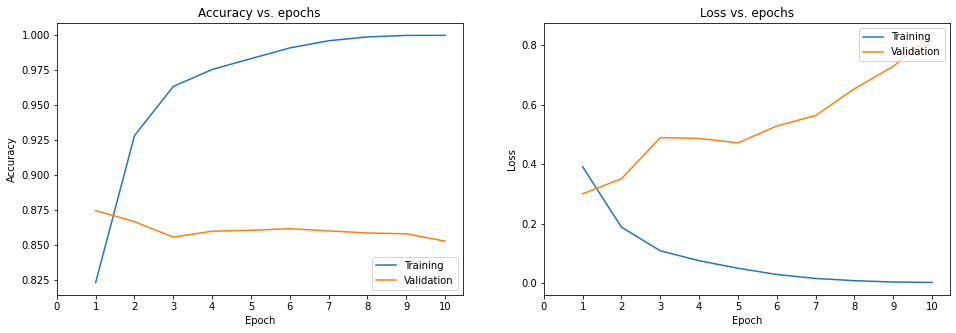

2021-07-21 06:54:04,352: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/pg_default


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/pg_default
----------------------------------------evaluate----------------------------------------


2021-07-21 06:54:59,517: INFO: test loss:0.3003
2021-07-21 06:54:59,517: INFO: test accuracy:0.8744
2021-07-21 06:54:59,519: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/results.json
2021-07-21 06:54:59,520: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/results.json
2021-07-21 06:54:59,521: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sequence_map.generator


----------------------------------------save model results and generator----------------------------------------


2021-07-21 06:54:59,525: WARNING: Please add `keras.layers.InputLayer` instead of `keras.Input` to Sequential model. `keras.Input` is intended to be used by Functional model.


2021-07-21 06:54:59,563: WARNING: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sequence_map.layer/assets


2021-07-21 06:55:00,087: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sequence_map.layer/assets
2021-07-21 06:55:00,107: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sequence_map.generator
2021-07-21 06:55:00,108: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/rnn_lstm_fasttext


----------------------------------------confusion matrix----------------------------------------


2021-07-21 06:55:09,175: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sequence_map.generator


2021-07-21 06:55:09,522: WARNING: No training configuration found in save file, so the model was *not* compiled. Compile it manually.


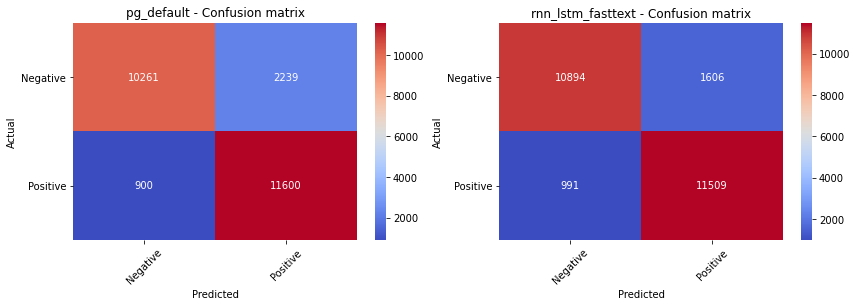

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc,train_top2_accuracy,test_top2_accuracy
1,rnn_lstm_fasttext,1282802,1487.2,0.2090,0.2680,0.9174,0.8961,0.9739,0.9592,NaN,NaN
2,mlp2,5120770,170.9,0.1106,0.2639,0.9741,0.8960,0.9972,0.9591,1.0,1.0
3,sepcnn,4043682,252.0,0.1779,0.2756,0.9349,0.8909,0.9832,0.9557,NaN,NaN
4,mlp1,5120770,59.4,0.1378,0.2756,0.9544,0.8866,0.9912,0.9559,1.0,1.0
5,embedding1,4000802,277.3,0.1530,0.2744,0.9501,0.8859,0.9888,0.9543,1.0,1.0
6,embedding2,4000802,231.9,0.1556,0.2801,0.9484,0.8830,0.9893,0.9532,NaN,NaN
7,pg_default,6184002,543.3,0.1879,0.3003,0.9287,0.8744,0.9835,0.9515,NaN,NaN
8,rnn_lstm,5123002,560.4,0.6821,0.6947,0.5258,0.5057,0.5369,0.4975,NaN,NaN
9,sepcnn_fasttext,50182,459.8,0.6933,0.6933,0.5000,0.5000,0.5090,0.5083,NaN,NaN


In [42]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.models.pooled_gru1(helper, name='pg_default')
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

#### pg_fasttext

2021-07-21 06:55:50,617: INFO: model_params.pg_fasttext.dropout=0.4
2021-07-21 06:55:50,618: INFO: model_params.pg_fasttext.units=80
2021-07-21 06:55:50,619: INFO: max_features=20000
2021-07-21 06:55:50,619: INFO: model_params.pg_fasttext.embedding_dim=300
2021-07-21 06:55:51,040: INFO: output_bias=[-0.69314718 -0.69314718]
2021-07-21 06:55:51,047: INFO: model_params.pg_fasttext.learning_rate=0.0005
2021-07-21 06:55:51,048: INFO: model_params.pg_fasttext.clip_value=None
2021-07-21 06:55:51,053: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/pg_fasttext
2021-07-21 06:55:51,056: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/pg_fasttext, monitor=val_accuracy)
2021-07-21 06:55:51,056: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-07-21 06:55:51,057: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
202

Model: "pg_fasttext"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 500, 300)     6000000     input_15[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 500, 300)     0           embedding_9[0][0]                
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 500, 160)     183360      spatial_dropout1d_1[0][0]        
________________________________________________________________________________________

2021-07-21 06:56:37,227: WARNING: Found untraced functions such as gru_cell_7_layer_call_and_return_conditional_losses, gru_cell_7_layer_call_fn, gru_cell_8_layer_call_and_return_conditional_losses, gru_cell_8_layer_call_fn, gru_cell_7_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/pg_fasttext/assets


2021-07-21 06:56:38,620: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/pg_fasttext/assets


Epoch 2/10
Epoch 00002: Still keep learning rate 0.0005 instead of 0.001
781/781 [==============================] - 34s 44ms/step - loss: 0.2953 - accuracy: 0.8769 - val_loss: 0.2566 - val_accuracy: 0.8933


2021-07-21 06:57:21,556: WARNING: Found untraced functions such as gru_cell_7_layer_call_and_return_conditional_losses, gru_cell_7_layer_call_fn, gru_cell_8_layer_call_and_return_conditional_losses, gru_cell_8_layer_call_fn, gru_cell_7_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/pg_fasttext/assets


2021-07-21 06:57:23,008: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/pg_fasttext/assets


Epoch 3/10
Epoch 00003: Still keep learning rate 0.0005 instead of 0.001
781/781 [==============================] - 34s 44ms/step - loss: 0.2677 - accuracy: 0.8911 - val_loss: 0.2553 - val_accuracy: 0.8932
Epoch 4/10
Epoch 00004: Still keep learning rate 0.0005 instead of 0.001
781/781 [==============================] - 34s 44ms/step - loss: 0.2448 - accuracy: 0.9008 - val_loss: 0.2409 - val_accuracy: 0.9010


2021-07-21 06:58:41,584: WARNING: Found untraced functions such as gru_cell_7_layer_call_and_return_conditional_losses, gru_cell_7_layer_call_fn, gru_cell_8_layer_call_and_return_conditional_losses, gru_cell_8_layer_call_fn, gru_cell_7_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/pg_fasttext/assets


2021-07-21 06:58:42,959: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/pg_fasttext/assets


Epoch 5/10
Epoch 00005: Still keep learning rate 0.0005 instead of 0.001
781/781 [==============================] - 34s 44ms/step - loss: 0.2296 - accuracy: 0.9074 - val_loss: 0.2422 - val_accuracy: 0.9003
Epoch 6/10
Epoch 00006: Still keep learning rate 0.0005 instead of 0.001
781/781 [==============================] - 34s 44ms/step - loss: 0.2134 - accuracy: 0.9151 - val_loss: 0.2292 - val_accuracy: 0.9061


2021-07-21 07:00:01,063: WARNING: Found untraced functions such as gru_cell_7_layer_call_and_return_conditional_losses, gru_cell_7_layer_call_fn, gru_cell_8_layer_call_and_return_conditional_losses, gru_cell_8_layer_call_fn, gru_cell_7_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/pg_fasttext/assets


2021-07-21 07:00:02,544: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/pg_fasttext/assets


Epoch 7/10
Epoch 00007: Still keep learning rate 0.0005 instead of 0.001
781/781 [==============================] - 35s 44ms/step - loss: 0.1997 - accuracy: 0.9223 - val_loss: 0.2318 - val_accuracy: 0.9052
Epoch 8/10
Epoch 00008: Still keep learning rate 0.0005 instead of 0.001
781/781 [==============================] - 34s 44ms/step - loss: 0.1860 - accuracy: 0.9281 - val_loss: 0.2263 - val_accuracy: 0.9082


2021-07-21 07:01:19,970: WARNING: Found untraced functions such as gru_cell_7_layer_call_and_return_conditional_losses, gru_cell_7_layer_call_fn, gru_cell_8_layer_call_and_return_conditional_losses, gru_cell_8_layer_call_fn, gru_cell_7_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/pg_fasttext/assets


2021-07-21 07:01:21,352: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/pg_fasttext/assets


Epoch 9/10
Epoch 00009: Still keep learning rate 0.0005 instead of 0.001
781/781 [==============================] - 34s 44ms/step - loss: 0.1748 - accuracy: 0.9347 - val_loss: 0.2302 - val_accuracy: 0.9072
Epoch 10/10
Epoch 00010: Still keep learning rate 0.0005 instead of 0.001
781/781 [==============================] - 34s 44ms/step - loss: 0.1606 - accuracy: 0.9388 - val_loss: 0.2396 - val_accuracy: 0.9040


2021-07-21 07:02:30,634: INFO: finish training [elapsed time: 399.58 seconds]


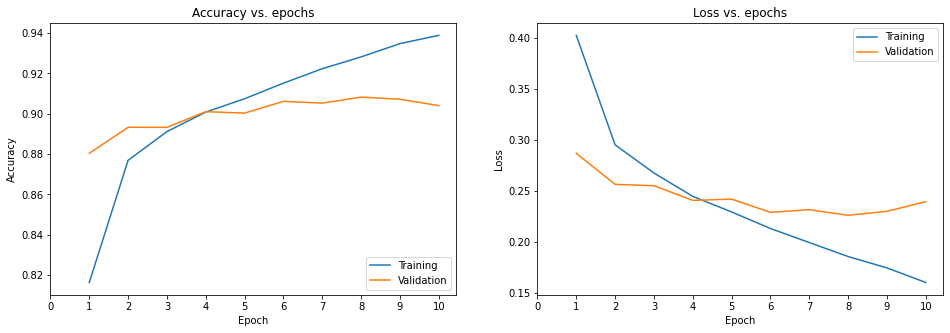

2021-07-21 07:02:31,134: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/pg_fasttext


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/pg_fasttext
----------------------------------------evaluate----------------------------------------


2021-07-21 07:03:29,547: INFO: test loss:0.2263
2021-07-21 07:03:29,548: INFO: test accuracy:0.9082
2021-07-21 07:03:29,550: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/results.json
2021-07-21 07:03:29,551: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/results.json
2021-07-21 07:03:29,552: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sequence_map.generator


----------------------------------------save model results and generator----------------------------------------


2021-07-21 07:03:29,555: WARNING: Please add `keras.layers.InputLayer` instead of `keras.Input` to Sequential model. `keras.Input` is intended to be used by Functional model.


2021-07-21 07:03:29,593: WARNING: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sequence_map.layer/assets


2021-07-21 07:03:30,115: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sequence_map.layer/assets
2021-07-21 07:03:30,135: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sequence_map.generator
2021-07-21 07:03:30,136: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/rnn_lstm_fasttext


----------------------------------------confusion matrix----------------------------------------


2021-07-21 07:03:38,242: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sequence_map.generator


2021-07-21 07:03:38,574: WARNING: No training configuration found in save file, so the model was *not* compiled. Compile it manually.


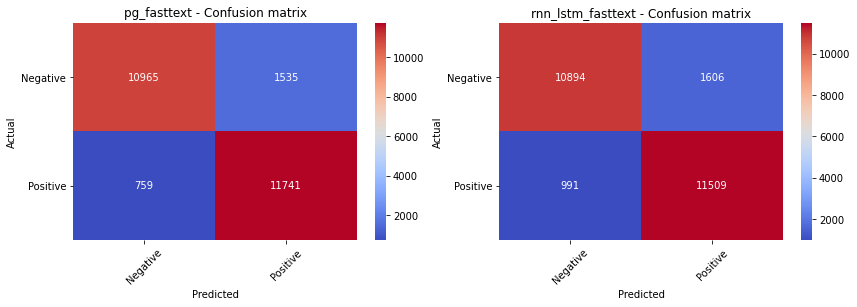

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc,train_top2_accuracy,test_top2_accuracy
1,pg_fasttext,184002,399.1,0.1514,0.2263,0.9427,0.9082,0.9876,0.9716,NaN,NaN
2,rnn_lstm_fasttext,1282802,1487.2,0.2090,0.2680,0.9174,0.8961,0.9739,0.9592,NaN,NaN
3,mlp2,5120770,170.9,0.1106,0.2639,0.9741,0.8960,0.9972,0.9591,1.0,1.0
4,sepcnn,4043682,252.0,0.1779,0.2756,0.9349,0.8909,0.9832,0.9557,NaN,NaN
5,mlp1,5120770,59.4,0.1378,0.2756,0.9544,0.8866,0.9912,0.9559,1.0,1.0
6,embedding1,4000802,277.3,0.1530,0.2744,0.9501,0.8859,0.9888,0.9543,1.0,1.0
7,embedding2,4000802,231.9,0.1556,0.2801,0.9484,0.8830,0.9893,0.9532,NaN,NaN
8,pg_default,6184002,543.3,0.1879,0.3003,0.9287,0.8744,0.9835,0.9515,NaN,NaN
9,rnn_lstm,5123002,560.4,0.6821,0.6947,0.5258,0.5057,0.5369,0.4975,NaN,NaN
10,sepcnn_fasttext,50182,459.8,0.6933,0.6933,0.5000,0.5000,0.5090,0.5083,NaN,NaN


In [43]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.models.pooled_gru1(helper, name='pg_ft', 
                       embedding_matrix=embedding_matrix_fasttext, 
                       is_embedding_trainable=False)
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

## 评估

### 最佳模型

In [59]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10)

2021-07-21 07:13:00,476: INFO: getting results for /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb
2021-07-21 07:13:00,477: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/results.json


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc,train_top2_accuracy,test_top2_accuracy
1,pg_fasttext,184002,399.1,0.1514,0.2263,0.9427,0.9082,0.9876,0.9716,NaN,NaN
2,rnn_lstm_fasttext,1282802,1487.2,0.2090,0.2680,0.9174,0.8961,0.9739,0.9592,NaN,NaN
3,mlp2,5120770,170.9,0.1106,0.2639,0.9741,0.8960,0.9972,0.9591,1.0,1.0
4,sepcnn,4043682,252.0,0.1779,0.2756,0.9349,0.8909,0.9832,0.9557,NaN,NaN
5,mlp1,5120770,59.4,0.1378,0.2756,0.9544,0.8866,0.9912,0.9559,1.0,1.0
6,embedding1,4000802,277.3,0.1530,0.2744,0.9501,0.8859,0.9888,0.9543,1.0,1.0
7,embedding2,4000802,231.9,0.1556,0.2801,0.9484,0.8830,0.9893,0.9532,NaN,NaN
8,pg_default,6184002,543.3,0.1879,0.3003,0.9287,0.8744,0.9835,0.9515,NaN,NaN
9,rnn_lstm,5123002,560.4,0.6821,0.6947,0.5258,0.5057,0.5369,0.4975,NaN,NaN
10,sepcnn_fasttext,50182,459.8,0.6933,0.6933,0.5000,0.5000,0.5090,0.5083,NaN,NaN


2021-07-21 07:06:19,396: INFO: getting results for /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb
2021-07-21 07:06:19,397: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/results.json
2021-07-21 07:06:19,398: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/pg_fasttext
2021-07-21 07:06:26,257: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sequence_map.generator


2021-07-21 07:06:26,657: WARNING: No training configuration found in save file, so the model was *not* compiled. Compile it manually.
2021-07-21 07:06:26,662: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/rnn_lstm_fasttext
2021-07-21 07:06:36,515: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sequence_map.generator


2021-07-21 07:06:36,930: WARNING: No training configuration found in save file, so the model was *not* compiled. Compile it manually.
2021-07-21 07:06:36,935: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/mlp2
2021-07-21 07:06:37,296: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/ngram_map.generator


2021-07-21 07:06:37,646: WARNING: No training configuration found in save file, so the model was *not* compiled. Compile it manually.
2021-07-21 07:06:37,651: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sepcnn
2021-07-21 07:06:38,232: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/sequence_map.generator


2021-07-21 07:06:38,606: WARNING: No training configuration found in save file, so the model was *not* compiled. Compile it manually.
2021-07-21 07:06:38,611: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/mlp1
2021-07-21 07:06:38,990: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/imdb/imdb_0721_p100/ngram_preproess.generator


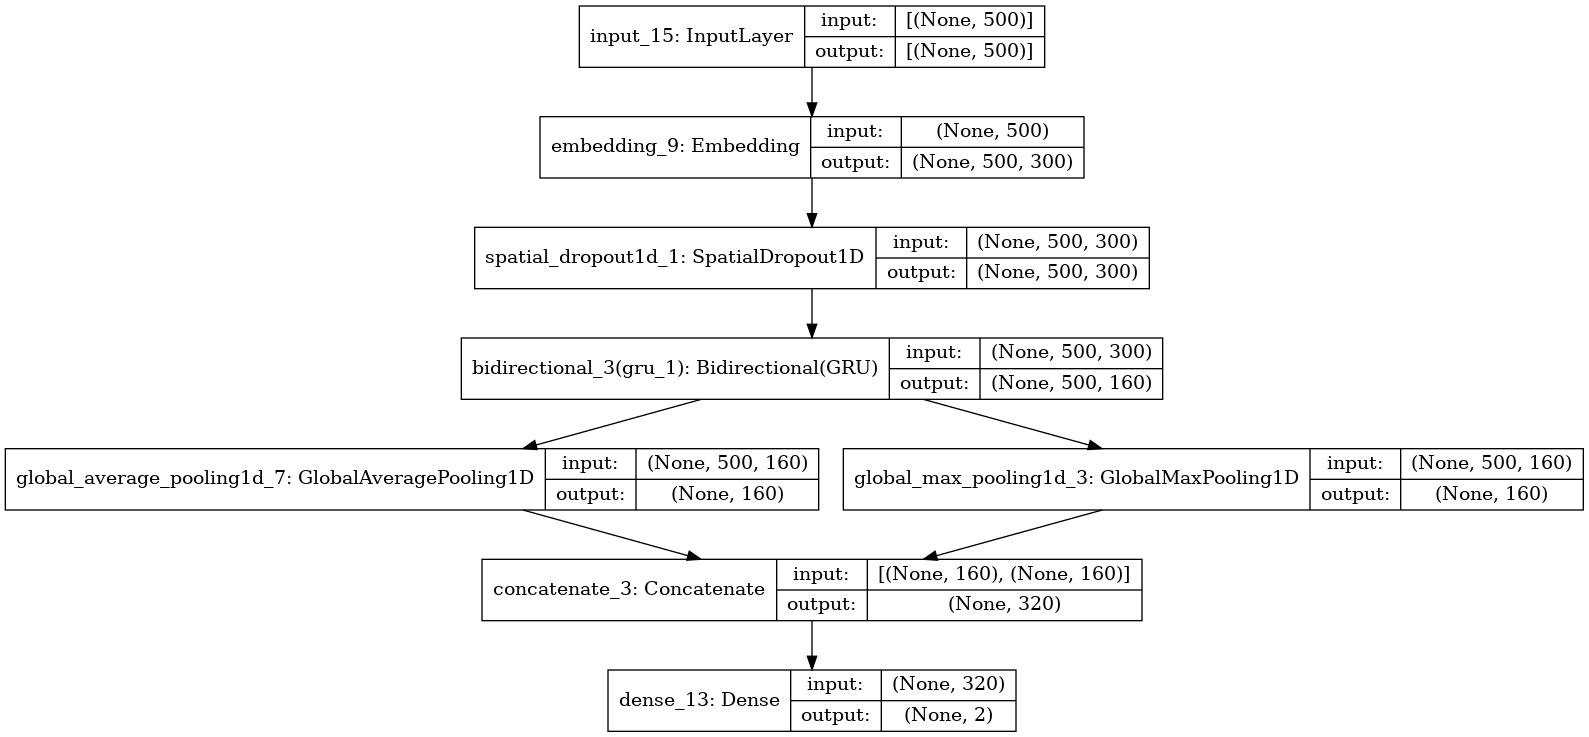

In [49]:
predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

----------------------------------------1. Positive----------------------------------------
When I first saw the movie, I thought it was sweet - a family movie. For the rest of the night and over the next couple of days, though, clever moments and funny lines kept creeping back into my thoughts and our conversation... There's a lot going on, classic elements of farce, good character acting, and Wendie Malick's story line is just hysterical. Labelling it a "feel-good movie" belies the wit and fun - it's smarter than it seems, just like "It's a Wonderful Life" is.


2021-07-21 07:06:59,457: WARNING: 5 out of the last 786 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fce5c706598> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2021-07-21 07:06:59,619: WARNING: 6 out of the last 787 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fd156fa8840> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


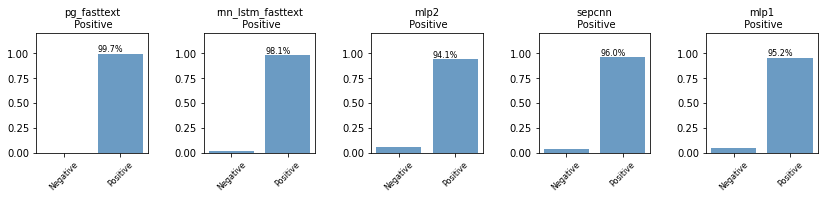

----------------------------------------2. Positive----------------------------------------
Five teens set out to do some camping in the Oregon wilderness, and despite being warned by the park ranger, they soon realize that something is lurking around in the backwoods waiting to strike.<br /><br />When it comes to old horror movies, the only one that keeps popping up in every conversation is Friday THE 13th, so I took it upon myself to find those good old horror movies that fell short for simply being compared to Friday THE 13th, JUST BEFORE DAWN just so happened to be among the ones I found, and was really very impressive, it wasn't as bland as some of the stuff you find today, it was very sharp in terms of character development as it had quite a few likable ones, and it has this very casual pace, its not in a hurry to get to the hack and slash bits, it takes its time to set the proper mood and tone and is very atmospheric and builds some killer suspense by letting you always have tha

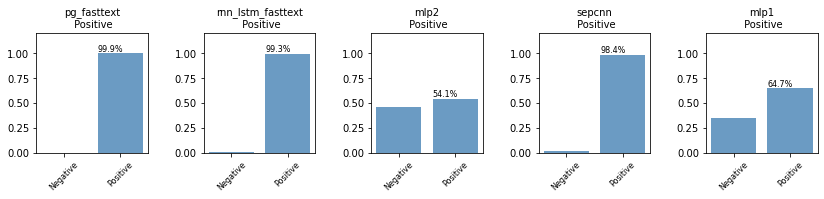

----------------------------------------3. Positive----------------------------------------
This is one of the anime films from The Animatrix collection, one of nine - the only one done in black and white, and the only one featuring Trinity. Richly textured and beautifully rendered in every way, and the animated version of Trinity definitely does her justice. If you're a fan of The Matrix, you will need to put this on your short list.


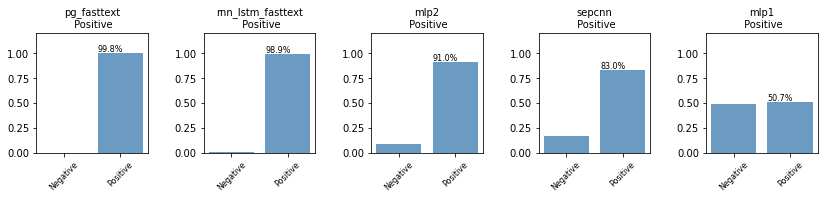

----------------------------------------4. Positive----------------------------------------
It is to typical of people complaining about something when they no nothing about it...So this is about a gay man falling for a straight women. First of all...This is a true story so you cant say its not believable Second its written by a gay man so the whole thing about this being against the gays are just plain stupid. Personally I think this was the best love story I've ever seen. And I am very pro gay. I think this shows that real love is about personality not just looks and sex. And it has nothing against anyone who is gay, straight or bi unlike so many other shows. Maybe we in Europe take to it more cus most TV here are a bit deeper and make you think more then American TV...Plus we don't fear when it comes to showing certain things.<br /><br />If you want something funny with one of Englands best (Lesley Sharp) and you want to see a decent believable love story without too much sap this i

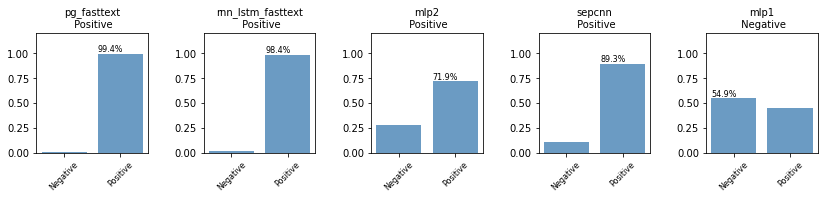

----------------------------------------5. Positive----------------------------------------
I really can't see why people seem to dislike this film. I found it very entertaining (of course the fact that it stars the gorgeous Laura Fraser is a bonus!) When I first heard about it, I thought it would be along the lines of a role-reversed "Weird Science" and, to an extent, this is true, however there is a twist which I really didn't see coming. Having seen the trailer on the DVD (which I hadn't seen before watching the film) I saw that the "twist" is actually shown in the trailer! Very strange.<br /><br />As the film progresses the "Weird Science" comparison fits less and less, and I think this is the better of the two films. Certainly there are some scenes which don't work wonderfully, but these are made up for by the enthusiasm of the young cast.<br /><br />In summary, I'd suggest that this is a fine example of a Sci-fi chick flick, and I don't think I've seen many of them!


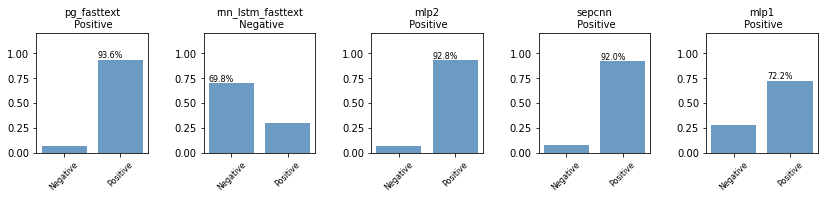

In [52]:
qtf.utils.plot_sample_text_analysis(predictors, test_texts, test_labels,
                                    sample_count=5, show_error_sample=False) 

----------------------------------------1. Positive----------------------------------------
The Falcon and the Snowman is based on a true story. Christopher Boyce, and Andrew Daulton Lee, (the titular traitors,) played by Timothy Hutton and Sean Penn, received their code- names from the KGB. Why? Boyce was an avid falconer and Lee was a coke head. The movie is based on a true story. It's based on the book of the same name. Another reviewer asked what was their motivation? Disillusionment it ain't. Ideology it ain't. (Pardon my bad grammar,) but I'm making a point here. What was it if it wasn't disillusionment or ideology? In a word, greed. By the time of the Boyce-Lee case, money became the great motivator and not ideology. Don't believe me? Then look at the Walker Family Spy Ring which was broken in the late '80s. Three spies did the worst damage to our national security in the '70s and '80s. John Walker, who began his career as a spy in the '60s, Christopher Boyce, and Andrew Daulton

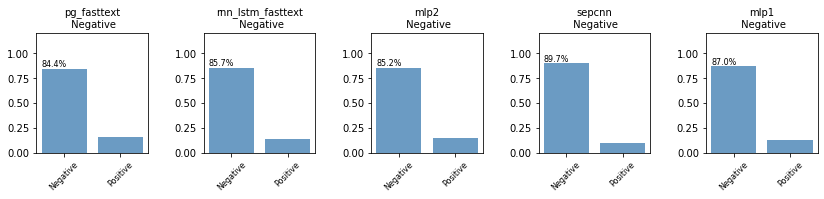

----------------------------------------2. Positive----------------------------------------
Semper Fi! I saw "The D.I." in 1957. Two-and-a-half -years later I joined the Corps.<br /><br />Web and company got it as right as they could in '57. Boot, in '59, was more like, in fact, exactly like, the Boot Camp shown in "Full Metal Jacket" - Yes. A black recruit, in my training platoon, was called "Snowball." I was called "Stick," because I was skinny as a rail. Every recruit had a nickname, some rather vile, that stuck with him through his service in the Corps. Getting smacked, or knocked on your ass, when you screwed-up was SOP. "Drop, and give me fifty," got to be ho-hum. Then, it turned into,"Drop, and give me two-hundred!"<br /><br />The D.I.'s were a bunch of sadistic bastards, but it was a controlled sadism, and with a primary purpose of keeping us stupid MoFos alive when we hit combat. 200 years of experience was ingrained in that "sadism," and everything the D.I. did, or said, had 

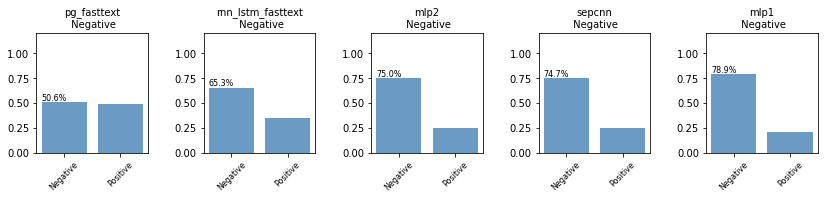

----------------------------------------3. Negative----------------------------------------
Following the advice of a friend, I got myself this movie. I'm very fond of computers in general - hence why a 1995 film about identity theft on the Internet could not be left unseen. I had some bad echoes about it, but in the end, I wasn't so disappointed : the story, though classical, is kind of interesting and must have been really new back in the days when it was released in theatres. I was gladly surprised when I figured out that contrary to what we usually see, computer-performed actions are somehow realistic, as they use Windows 3.x and normal computers. The storytelling is median and not bothering the viewer. The end is typically American. The actors' performance is globally OK, Sandra Bullock usually annoys me with her "oh my god why me" way to behave, but this time she seems to have controlled herself. I'd recommend that movie.


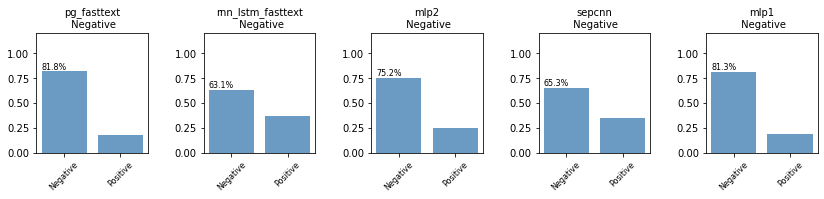

----------------------------------------4. Positive----------------------------------------
After Kenneth Opel's rousing story of the invigorated me back into the pleasure of reading during grade school, I had high hopes for this series. The story of an underdog bat voyaging across country to reunite with his colony captivated my imagination and resonated deeply with my burgeoning imagination.Upon hearing of this series, I began browsing Bardel Animation's site and liked what I saw. The character design looked impressive and the fast-paced plot seemed to have been stretched respectably across a thirteen episode arc. Much was my disappointment, then, when I decided to watch a rerun early one morn.<br /><br />The opening episode shows our hero, Shade Silverwing, pursuing a tiger moth in the deep hours of the night. Chirruping an echolocatory song, we see a nifty if crude CGI effect illuminate the moth, and the chase takes on a frenetic turn as the tiny insect creates numerous illusory co

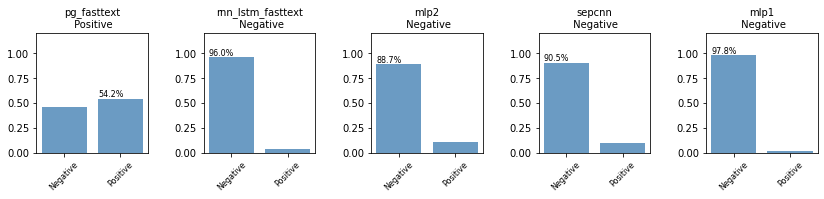

----------------------------------------5. Negative----------------------------------------
<br /><br />..this movie being one of them.<br /><br />I remember, in the middle of the movie, me and my friend just<br /><br />looked at each other, shaked our heads and laughed.. in despair.<br /><br />See it if you wish, if you feel that you have the time to waste<br /><br />and don´t mind 1.5 hrs of catatonia.


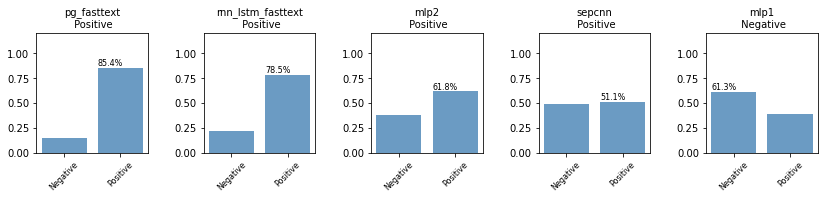

In [53]:
qtf.utils.plot_sample_text_analysis(predictors, test_texts, test_labels,
                                    sample_count=5, show_error_sample=True) 

### 评估

In [55]:
results = best_predictor.evaluate(test_texts, test_labels)
print(results)

predictions = best_predictor.predict(test_texts)
print(predictions.shape)

{'loss': 0.2263348400592804, 'accuracy': 0.908240020275116, 'mae': 2.2346582412719727}
(25000, 2)


In [56]:
top1_predictions = best_predictor.predict_top_k(test_texts, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

,precision,recall,f1
Negative,0.935261,0.87720,0.905301
Positive,0.884378,0.93928,0.911002


----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative     0.9353    0.8772    0.9053     12500
    Positive     0.8844    0.9393    0.9110     12500

    accuracy                         0.9082     25000
   macro avg     0.9098    0.9082    0.9082     25000
weighted avg     0.9098    0.9082    0.9082     25000



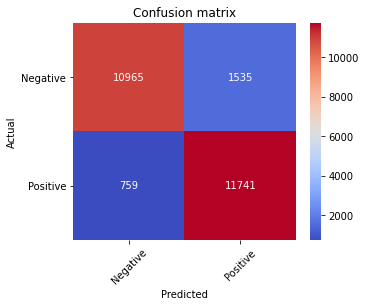

In [57]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## 参考

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)